Carter Grant and Ellie Angus
Data 5600

Group Data Analysis 2:
#Multiple Linear Regression and Real Estate

# ***Data Prep/Exploratory Data Analysis***

The primary objective of our analysis is to compare real estate data from Coldwell Banker Realty against other firms to identify the factors influencing listing prices. This analysis aims to provide insights to inform Coldwell Banker Realty's. We will now define our data, clean it, and prepare it for analysis.

Continuous Variables: Price, Baths, Sq Ft, Beds

Categorical Variables: Days on Market, Year Built, Agency Name

Key Variables for Analysis:
Price: This is our target variable.
Baths, Sq Ft, Beds: These are continuous variables that are important predictors of price.
Days on Market: This categorical variable may indicate how quickly properties sell, potentially influencing price.
Year Built: Another categorical variable that could be related to price, as newer properties may be more desirable.
Agency Name: This categorical variable may indicate if certain agencies tend to list higher-priced properties.

Our data is from a kaggle resource that has house listings around the US. There are around 32,000 individual listings, but we will take a random sample of 5000 to help with computation times.
( https://www.kaggle.com/datasets/gitadityamaddali/usa-real-estate-dataset-homes-com )


In [1]:
#import libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
df = pd.read_csv('/content/archive (4) (1).zip')
df.head()
#data exploration
df.dtypes

Unnamed: 0           int64
Price               object
Status              object
Sq Ft               object
Price per Sq Ft     object
Days on Market      object
Beds                object
Baths               object
Year Built         float64
Street Info         object
City                object
State               object
Zip Code            object
Description         object
Agent Name          object
Agency Name         object
dtype: object

In [3]:
#change price to be numeric and clean data
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace('[^\d.]', '', regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
non_numeric_prices = df['Price'][pd.to_numeric(df['Price'], errors='coerce').isnull()]
#price exploration
bottom_1_percent = df['Price'].quantile(0.01)
top_1_percent = df['Price'].quantile(0.99)
print(f"Bottom 1% of Price: {bottom_1_percent}")
print(f"Top 1% of Price: {top_1_percent}")

Bottom 1% of Price: 36842.0
Top 1% of Price: 2475000.0


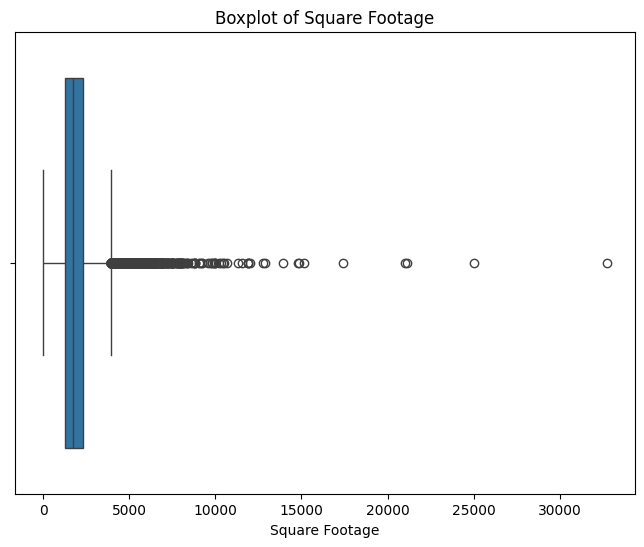

In [4]:
df['Year Built'] = pd.to_numeric(df['Year Built'], errors='coerce')
# Fill NaN values resulting from coercion with the median Year Built
df['Year Built'].fillna('NA', inplace=True)
df['Sq Ft'] = df['Sq Ft'].str.replace(',', '', regex=True)
# 2. Remove any non-digit characters
df['Sq Ft'] = df['Sq Ft'].str.replace('[^\d.]', '', regex=True)
# 3. Convert to numeric
df['Sq Ft'] = pd.to_numeric(df['Sq Ft'], errors='coerce')
# 4. Check for remaining
df['Sq Ft'].value_counts()
df = df[df['Sq Ft'] <= 50000]

#make plot to further explore data
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Sq Ft'])
plt.title('Boxplot of Square Footage')
plt.xlabel('Square Footage')
plt.show()

In [5]:
df['Baths'] = df['Baths'].astype(str).str.replace('[^\d.]', '', regex=True)
df['Baths'] = pd.to_numeric(df['Baths'], errors='coerce')
non_numeric_baths = df['Baths'][pd.to_numeric(df['Baths'], errors='coerce').isnull()]
#impute Baths values that are over 15 to the median
df = df.loc[df['Baths'] <= 15]
df['Beds'] = df['Beds'].astype(str).str.replace('[^\d.]', '', regex=True)
# 2. Convert to numeric
df['Beds'] = pd.to_numeric(df['Beds'], errors='coerce')
# 3. Check for remaining non-numeric values
non_numeric_baths = df['Beds'][pd.to_numeric(df['Beds'], errors='coerce').isnull()]
df = df.loc[df['Beds'] <= 20]
# Now, 'Baths' should be a continuous numeric column

In [6]:
#change status to be numeric and clean data, eliminating extreme outliers
df['Status'] = df['Status'].str.replace('Sold', '', regex=False)
df.rename(columns={'Status': 'Date Sold'}, inplace=True)
df['Days on Market'] = pd.to_numeric(df['Days on Market'].str.extract(r'(\d+)')[0], errors='coerce')
df['Days on Market'] = df['Days on Market'].fillna(0).astype(int)
df = df.loc[df['Days on Market'] <= 15000]

In [7]:
# Create a new column 'Coldwell Banker Realty' with 1 if Agency Name is 'Coldwell Banker Realty', 0 otherwise
df['Coldwell Banker Realty'] = (df['Agency Name'] == 'Coldwell Banker Realty').astype(int)
# Create a new column 'Other Agency' with 1 if Agency Name is not 'Coldwell Banker Realty', 0 otherwise
df['Other Agency'] = (df['Agency Name'] != 'Coldwell Banker Realty').astype(int)
# Convert the new columns to categorical
df['Coldwell Banker Realty'] = df['Coldwell Banker Realty'].astype(int)
df['Other Agency'] = df['Other Agency'].astype(int)
df.drop('Agency Name', axis=1, inplace=True)

In [8]:
#drop unneeded columns
df.drop(['Unnamed: 0', 'Street Info', 'Description', 'City', 'State', 'Zip Code','Agent Name', 'Date Sold', 'Price per Sq Ft'], axis=1, inplace=True)
df.head()

Price   Sq Ft  Days on Market  Beds  Baths Year Built  \
0  155000.0  2955.0               6   4.0    3.0     1973.0   
1  240000.0  1818.0              30   3.0    2.0     1974.0   
2  330000.0  2004.0               3   3.0    2.0     1983.0   
3  305000.0  1394.0               7   3.0    2.0     2018.0   
4  259900.0  1367.0               1   3.0    2.0     2004.0   

   Coldwell Banker Realty  Other Agency  
0                       0             1  
1                       0             1  
2                       0             1  
3                       0             1  
4                       0             1

The work above is most of our data cleaning, we made values easier to run coorelations, dropped unneeded columns, and changed needed values,will now start working with missing data/renaming columns.

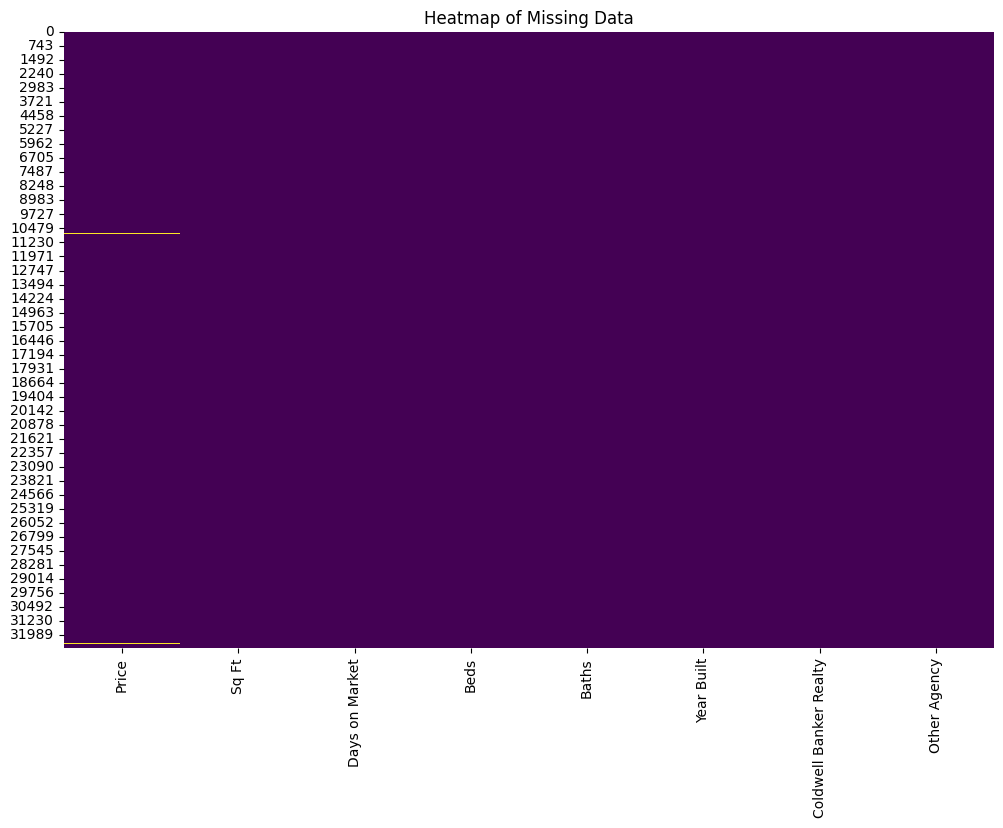

Price         Sq Ft  Days on Market          Beds         Baths  \
count  3.187200e+04  31915.000000    31915.000000  31915.000000  31915.000000   
mean   5.030640e+05   1907.175623       45.522670      3.213254      2.260332   
std    5.326283e+06    999.867672      112.519899      1.071672      0.949446   
min    1.000000e+00      0.000000        0.000000      1.000000      0.500000   
25%    2.399000e+05   1274.000000        4.000000      3.000000      2.000000   
50%    3.599000e+05   1719.000000       18.000000      3.000000      2.000000   
75%    5.350625e+05   2327.000000       64.000000      4.000000      3.000000   
max    9.450000e+08  25000.000000    11397.000000     16.000000     13.500000   

       Coldwell Banker Realty  Other Agency  
count            31915.000000  31915.000000  
mean                 0.016607      0.983393  
std                  0.127794      0.127794  
min                  0.000000      0.000000  
25%                  0.000000      1.000000  
50%                  0.000000      1.000000  
75%                  0.000000      1.000000  
max                  1.000000      1.000000

In [9]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title('Heatmap of Missing Data')
plt.show()
df.describe()

Dealt with missing data appropriately, next will be to randomly sample 5000 rows.

In [10]:
#randomly sample data
sampled_df = df.sample(n=5000, random_state=16)
sampled_df.head()

Price   Sq Ft  Days on Market  Beds  Baths Year Built  \
28731  515000.0  1640.0               5   3.0    2.0     1986.0   
27976  249900.0  2186.0              23   2.0    2.0     1982.0   
10951  600000.0  2434.0             474   4.0    3.0     2023.0   
24246  398000.0  1554.0              48   3.0    2.0     1998.0   
4987   150000.0   751.0              54   2.0    1.0     1964.0   

       Coldwell Banker Realty  Other Agency  
28731                       0             1  
27976                       0             1  
10951                       0             1  
24246                       0             1  
4987                        0             1

In [11]:
#change year built from object to int
# Replace 'NA' with NaN which can be handled by pd.to_numeric
sampled_df['Year Built'] = sampled_df['Year Built'].replace('NA', pd.NA)
# Now convert to numeric, errors='coerce' will convert invalid parsing as NaN
sampled_df['Year Built'] = pd.to_numeric(sampled_df['Year Built'], errors='coerce')
# Finally convert to int, NaNs will become <NA> which is nullable integer type in pandas
sampled_df['Year Built'] = sampled_df['Year Built'].astype('Int64')

# ***Multiple Linear Regression***

In [12]:
sampled_df.dtypes

Price                     float64
Sq Ft                     float64
Days on Market              int64
Beds                      float64
Baths                     float64
Year Built                  Int64
Coldwell Banker Realty      int64
Other Agency                int64
dtype: object

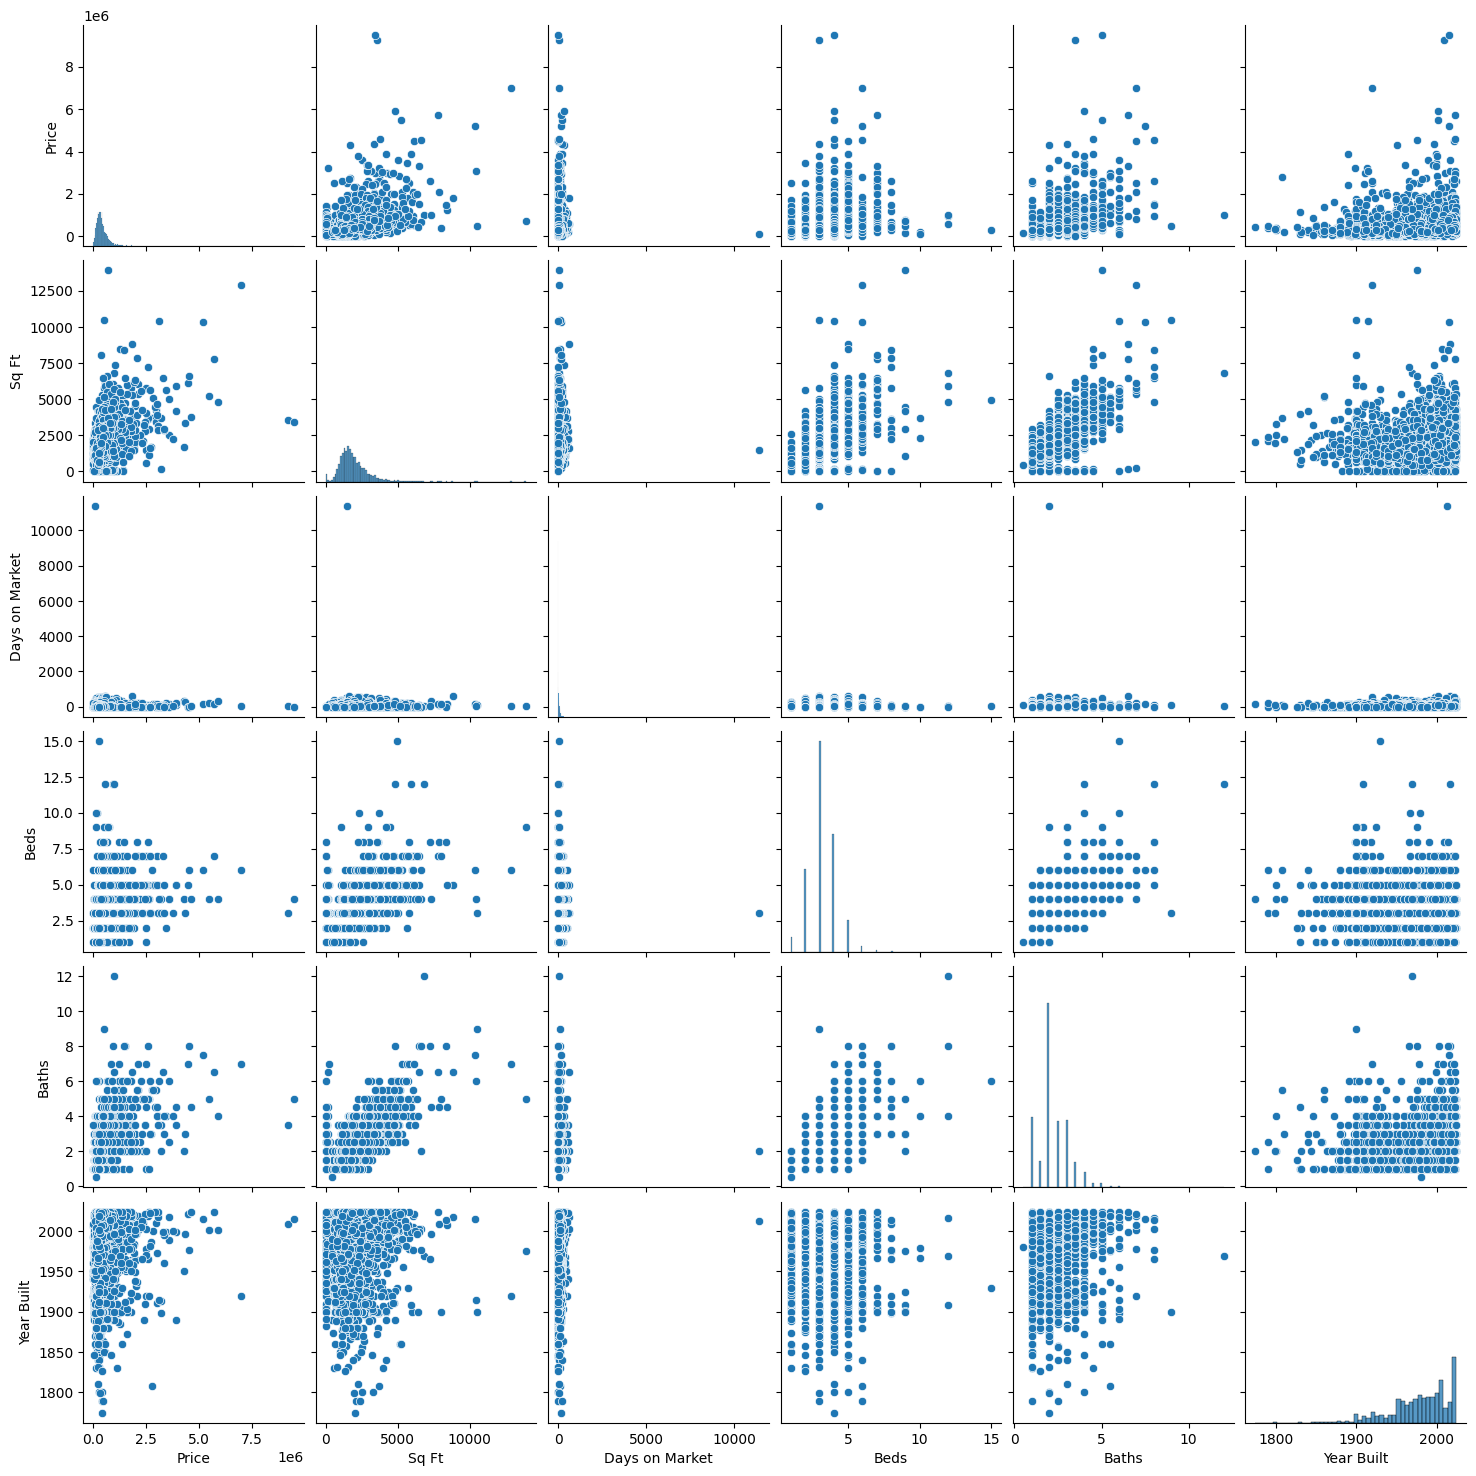

In [13]:
#scatterplot matrix created with variables used in our analysis
sns.pairplot(sampled_df[['Price', 'Sq Ft', 'Days on Market', 'Beds', 'Baths', 'Year Built']])
plt.show()

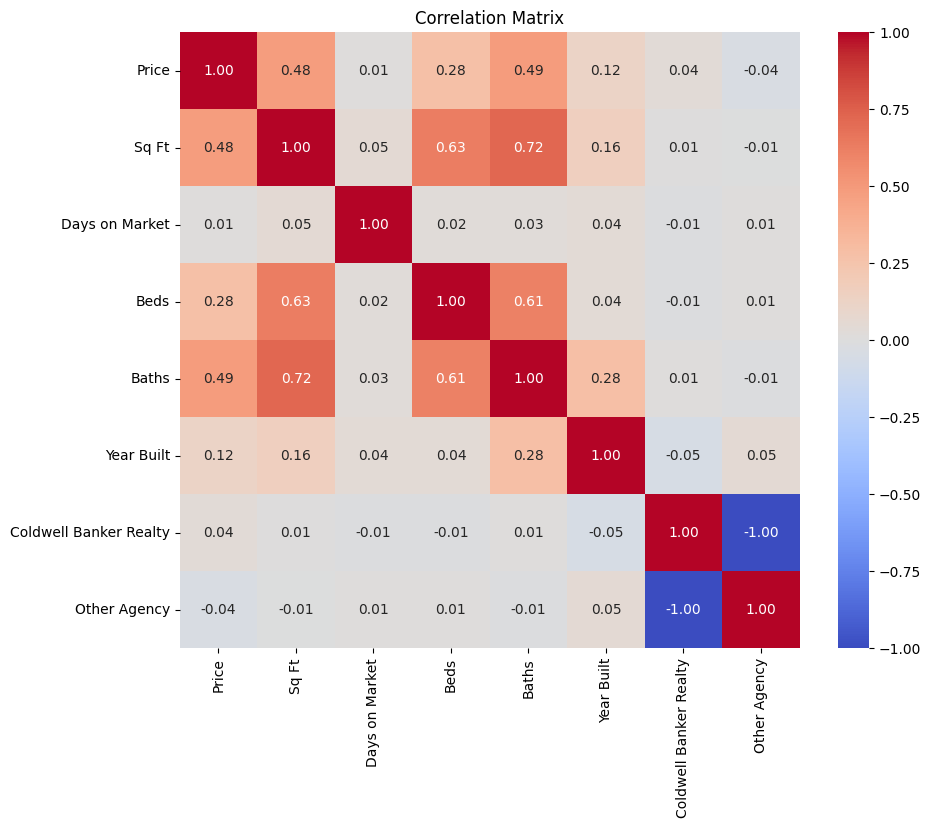

In [14]:
correlation_matrix = sampled_df.corr()
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [15]:

# Define y and X with the transformed dependent variable
y_transformed = sampled_df['Price']
X_transformed = sampled_df[['Sq Ft', 'Days on Market', 'Beds', 'Baths', 'Year Built', 'Coldwell Banker Realty']]

# --- Detailed cleaning for each column ---

# 1. 'Sq Ft'
if X_transformed['Sq Ft'].dtype == 'object':
    X_transformed['Sq Ft'] = pd.to_numeric(X_transformed['Sq Ft'].str.replace(',', ''), errors='coerce')
else:
    X_transformed['Sq Ft'] = pd.to_numeric(X_transformed['Sq Ft'], errors='coerce')

# 2. 'Days on Market'
X_transformed['Days on Market'] = pd.to_numeric(X_transformed['Days on Market'], errors='coerce')

# 3. 'Beds'
X_transformed['Beds'] = pd.to_numeric(X_transformed['Beds'], errors='coerce')

# 4. 'Baths'
X_transformed['Baths'] = pd.to_numeric(X_transformed['Baths'], errors='coerce')

# 5. 'Year Built'
X_transformed['Year Built'] = pd.to_numeric(X_transformed['Year Built'], errors='coerce')

# Fill NaN values in 'Year Built' with 0
X_transformed['Year Built'] = X_transformed['Year Built'].fillna(0)  # Fill NaN with 0

# --- End of detailed cleaning ---

# Convert 'Year Built' to standard int64 using numpy.astype()
X_transformed['Year Built'] = X_transformed['Year Built'].astype(np.int64)
# 6. One-hot encode 'Coldwell Banker Realty' if present
if 'Coldwell Banker Realty' in X_transformed.columns:
    X_transformed = pd.get_dummies(X_transformed, columns=['Coldwell Banker Realty'], drop_first=True, dtype=int)

# Convert entire DataFrame to numeric
X_transformed = X_transformed.apply(pd.to_numeric, errors='coerce')

# Print data types for inspection
print("Data types after cleaning:", X_transformed.dtypes)

# Add constant
X_transformed = sm.add_constant(X_transformed)

# Combine X and y for cleaning
data_transformed = pd.concat([X_transformed, y_transformed], axis=1)

# Drop rows with any NaN values
data_transformed = data_transformed.dropna()

# Split back into X and y
X_transformed = data_transformed.iloc[:, :-1]  # All columns except the last (Log_Price)
y_transformed = data_transformed.iloc[:, -1]   # Only the last column (Log_Price)

# Fit the model
mod_transformed = sm.OLS(y_transformed, X_transformed)
res_transformed = mod_transformed.fit()

# Output the summary
print(res_transformed.summary())

# Store residuals and fitted values
sampled_df['residuals_transformed'] = res_transformed.resid
sampled_df['fittedvalues_transformed'] = res_transformed.fittedvalues

Data types after cleaning: Sq Ft                       float64
Days on Market                int64
Beds                        float64
Baths                       float64
Year Built                    int64
Coldwell Banker Realty_1      int64
dtype: object
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     327.3
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        05:22:21   Log-Likelihood:                -71387.
No. Observations:                4991   AIC:                         1.428e+05
Df Residuals:                    4984   BIC:                         1.428e+05
Df Model:                           6                                         
Covariance Type:            nonr

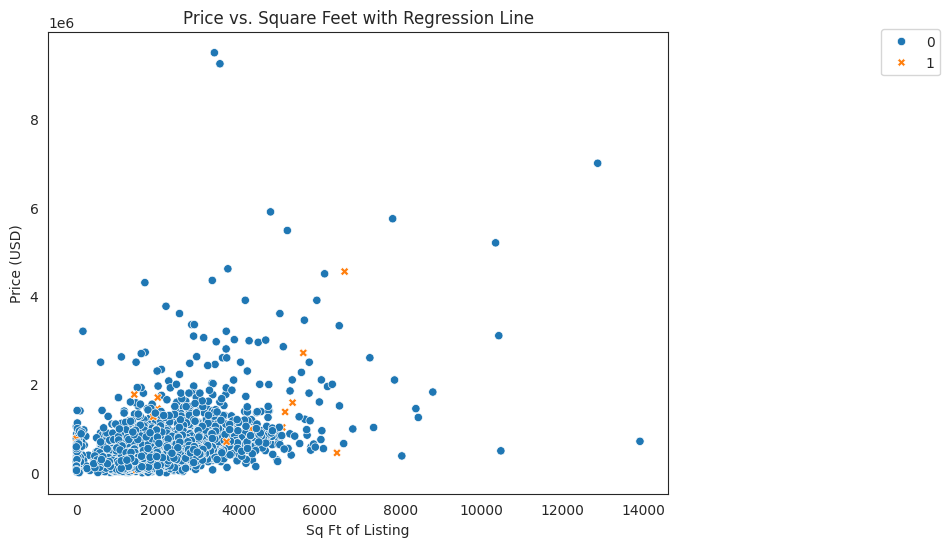

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Step 1: Fit the model
# Assuming 'Price' contains the logged values (log(Price))
X = sampled_df[['Sq Ft', 'Coldwell Banker Realty']]  # Use single categorical variable
y = sampled_df['Price']  # Use already logged Price
X = pd.get_dummies(X, drop_first=True)  # One-hot encode the categorical variable
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
res_transformed = model

# Step 2: Prepare data for predictions
prediction_data = pd.DataFrame({
    'Sq Ft': sampled_df['Sq Ft'],
    'Coldwell Banker Realty': sampled_df['Coldwell Banker Realty'],
})

# One-hot encode the prediction data
prediction_data = pd.get_dummies(prediction_data, drop_first=True)

# Predict log price values
prediction_data['Predicted_Price'] = model.predict(sm.add_constant(prediction_data))

# Step 3: Create the plot
sns.set_style("white")
plt.figure(figsize=(8, 6))

# Scatter plot of actual prices
sns.scatterplot(data=sampled_df,
                x='Sq Ft',
                y='Price',
                hue='Coldwell Banker Realty',
                style='Coldwell Banker Realty')

# Line plot of predicted prices
sns.lineplot(data=prediction_data,
             x='Sq Ft',
             y='Predicted_Price',  # Use the predicted prices
             hue=sampled_df['Coldwell Banker Realty'],
             style=sampled_df['Coldwell Banker Realty'],
             legend=False)

plt.xlabel('Sq Ft of Listing')
plt.ylabel('Price (USD)')
plt.title('Price vs. Square Feet with Regression Line')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.02))
plt.show()

In [17]:
# Log transformation of y if needed
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler
y_transformed, _ = boxcox(y_transformed + 1) #y_transformed is ndarray after this line
y_transformed = pd.Series(y_transformed, index=X_transformed.index) #Convert to Pandas Series
scaler = MinMaxScaler()
from scipy.stats import boxcox
X_transformed['Beds'], _ = boxcox(X_transformed['Beds'] + 1)  # Adding 1 to avoid zeros
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
X_transformed['Days on Market'] = pt.fit_transform(X_transformed[['Days on Market']])
X_transformed['Baths'] = np.log1p(X_transformed['Baths'])
X_transformed['Sq Ft'] = np.log1p(X_transformed['Sq Ft'])  # log(x + 1) to handle zeros
X_transformed[['Year Built']] = scaler.fit_transform(X_transformed[['Year Built']])
# Convert to numeric in case any object types remain
X_transformed = X_transformed.apply(pd.to_numeric, errors='coerce')
# Add constant for intercept
X_transformed = sm.add_constant(X_transformed)
# Combine X and y for cleaning
data_transformed = pd.concat([X_transformed, y_transformed], axis=1)
# Drop rows with any NaN values
data_transformed = data_transformed.dropna()
# Split back into X and y
X_transformed = data_transformed.iloc[:, :-1]  # All columns except the last (Log_Price)
y_transformed = data_transformed.iloc[:, -1]   # Only the last column (Log_Price)
# Fit the model with the transformed variables
mod_transformed = sm.OLS(y_transformed, X_transformed)
res_transformed = mod_transformed.fit()
# Output the summary of the transformed model
print(res_transformed.summary())
# Store residuals and fitted values
sampled_df['residuals_transformed'] = res_transformed.resid
sampled_df['fittedvalues_transformed'] = res_transformed.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     387.7
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        05:22:22   Log-Likelihood:                -14989.
No. Observations:                4991   AIC:                         2.999e+04
Df Residuals:                    4984   BIC:                         3.004e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_transformed.columns
vif_data["VIF"] = [variance_inflation_factor(X_transformed.values, i) for i in range(X_transformed.shape[1])]
print(vif_data)


                   Variable         VIF
0                     const  152.589083
1                     Sq Ft    1.416868
2            Days on Market    1.053218
3                      Beds    1.688742
4                     Baths    1.716151
5                Year Built    1.022503
6  Coldwell Banker Realty_1    1.001202


<Figure size 1000x600 with 0 Axes>

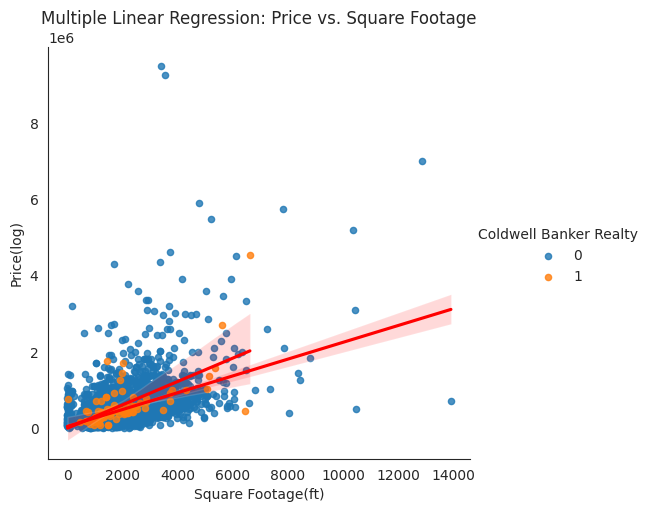

In [19]:
plt.figure(figsize=(10, 6))

sns.lmplot(x='Sq Ft', y='Price', data=sampled_df,
           hue='Coldwell Banker Realty',  # Move 'hue' to lmplot parameters
           scatter_kws={'s': 20},  # Adjust scatter point size if needed
           line_kws={'color': 'red'})  # Set regression line color

plt.xlabel('Square Footage(ft)')
plt.ylabel('Price(log)')
plt.title('Multiple Linear Regression: Price vs. Square Footage')
plt.show()

The above graph illustrates the positive relationship between square footage and price in real estate dataset. It also allows for comparison between Coldwell Banker Realty (the shorter line) and other agencies(the longer line), suggesting average listing price tends to be higher when a listing is represented by Coldwell Banker Realty.

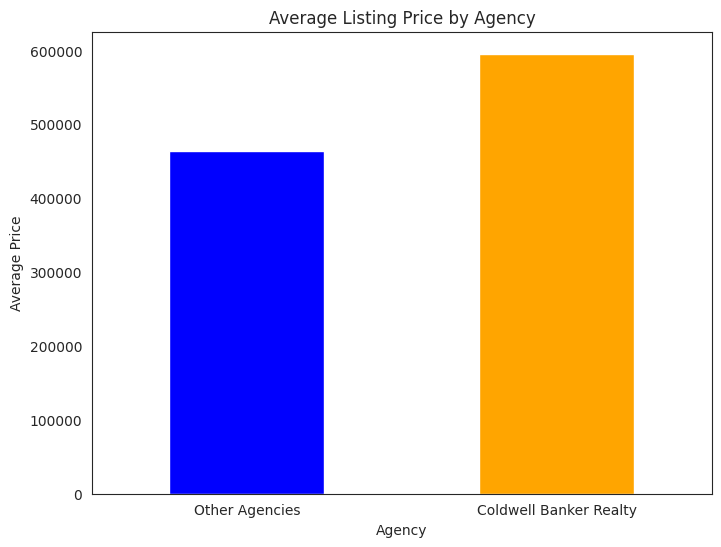

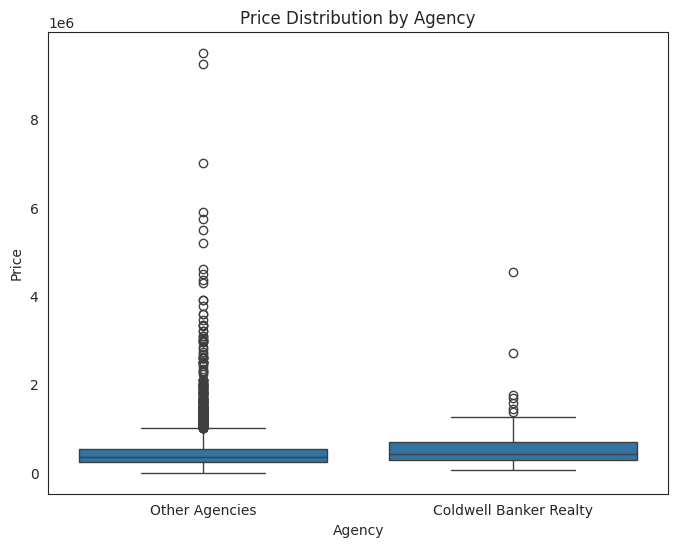

In [20]:

import matplotlib.pyplot as plt
# Group data by agency type and calculate the mean price
agency_prices = sampled_df.groupby('Coldwell Banker Realty')['Price'].mean()
# Create a bar plot to compare the average prices
plt.figure(figsize=(8, 6))
agency_prices.plot(kind='bar', color=['blue', 'orange'])
plt.title('Average Listing Price by Agency')
plt.xlabel('Agency')
plt.ylabel('Average Price')
plt.xticks([0, 1], ['Other Agencies', 'Coldwell Banker Realty'], rotation=0)
plt.show()
plt.figure(figsize=(8, 6))
sns.boxplot(x='Coldwell Banker Realty', y='Price', data=sampled_df)
plt.title('Price Distribution by Agency')
plt.xlabel('Agency')
plt.ylabel('Price')
plt.xticks([0, 1], ['Other Agencies', 'Coldwell Banker Realty'])
plt.show()

As seen from the above plots, average price for Coldwell Banker Realty tends to be higher on average than other agencies. The spread of property listings is also less compared to the other agencies listings.

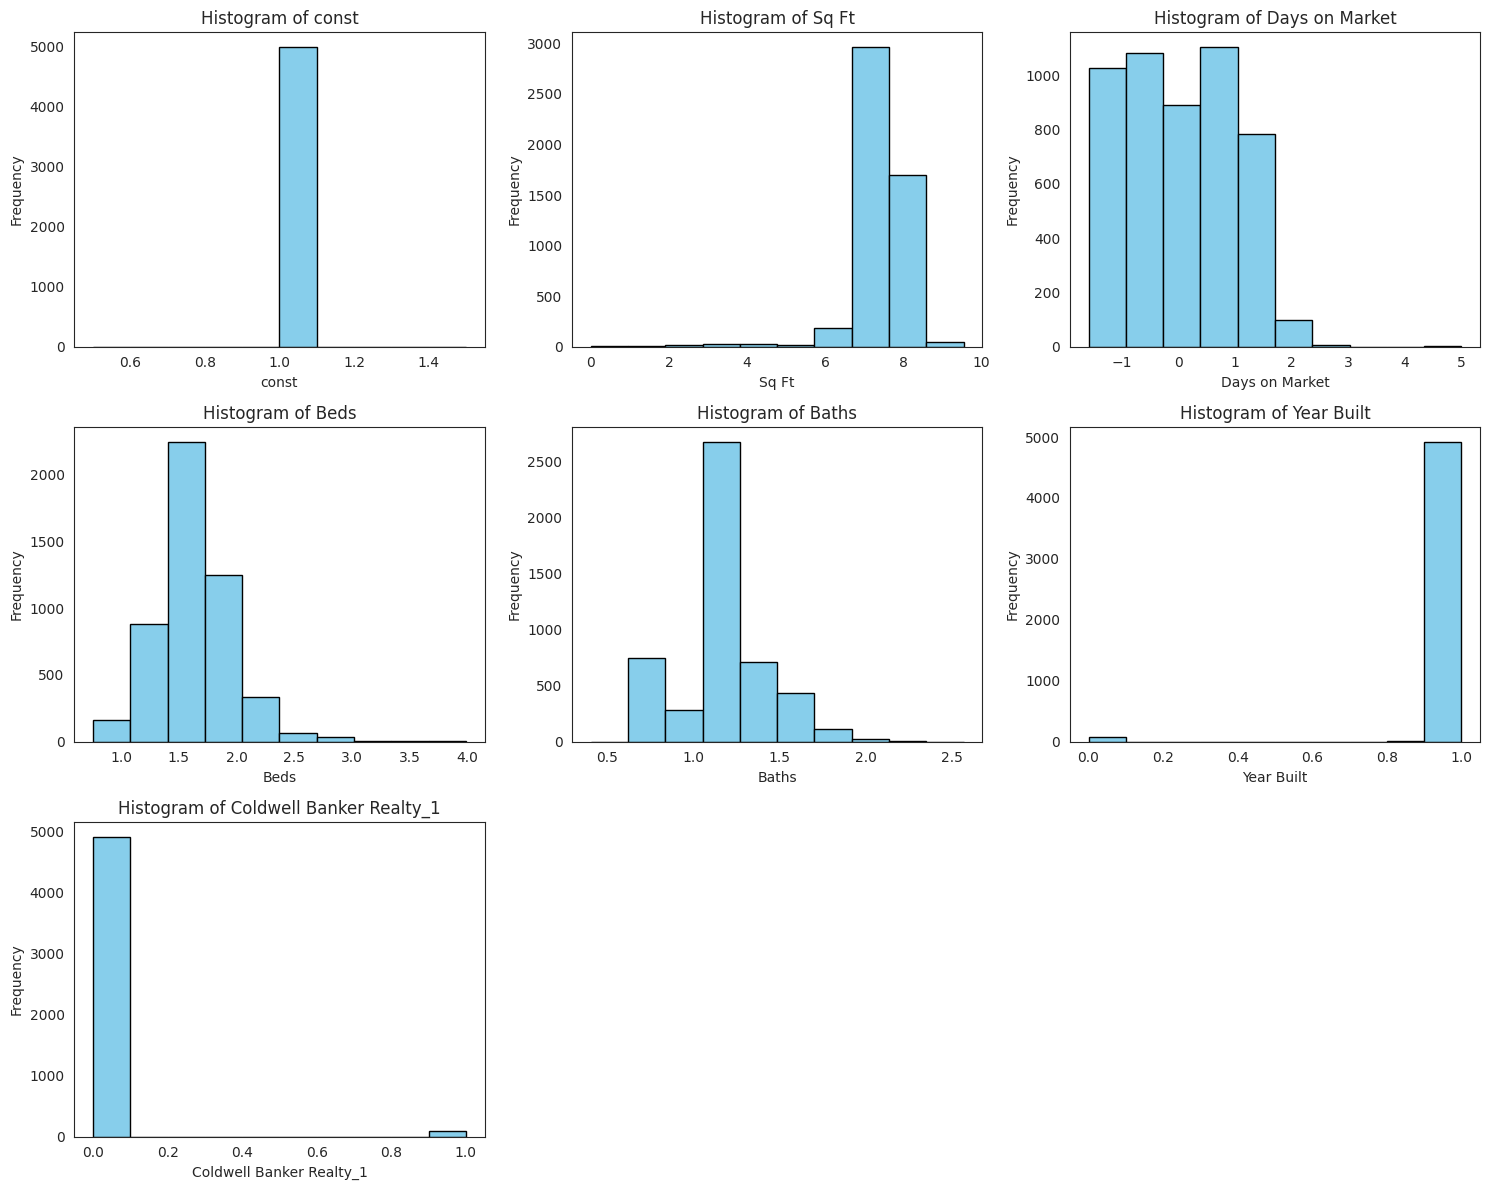

In [21]:
import matplotlib.pyplot as plt

# Set up the plotting area with a grid of subplots
num_columns = X_transformed.select_dtypes(include=['float64', 'int64']).columns
num_plots = len(num_columns)
ncols = 3  # Set the number of columns for the subplot grid
nrows = (num_plots // ncols) + (num_plots % ncols > 0)  # Calculate rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()  # Flatten in case of a 2D array of axes

# Loop through each column and plot the histogram
for i, col in enumerate(num_columns):
    X_transformed[col].plot(kind='hist', bins=10, ax=axes[i], color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


(L) The X's vs Y are linear

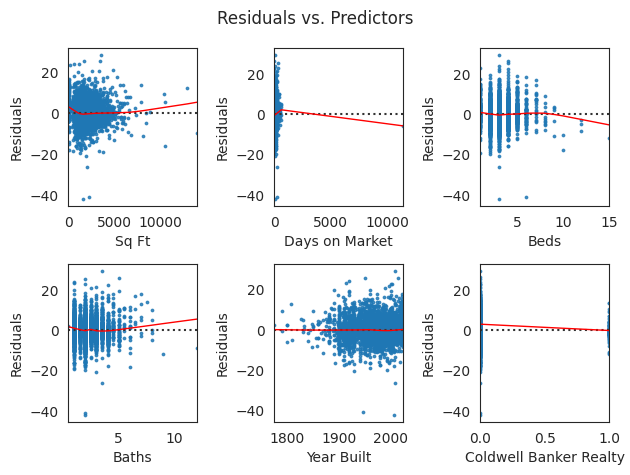

In [22]:
def res_vs_pred(variable, ax):
    sns.residplot(x = sampled_df[variable],
                  y = sampled_df['residuals_transformed'],
                  lowess = True,
                  scatter_kws = {'s': 3},
                  line_kws = {'color': 'red', 'lw': 1},
                  ax = ax)
    ax.set_xlabel(variable)
    ax.set_ylabel("Residuals")

fig, axes = plt.subplots(2, 3)
plt.suptitle("Residuals vs. Predictors")
res_vs_pred("Sq Ft", axes[0, 0])
res_vs_pred("Days on Market", axes[0, 1])
res_vs_pred("Beds", axes[0, 2])
res_vs_pred("Baths", axes[1, 0])
res_vs_pred("Year Built", axes[1, 1])
res_vs_pred("Coldwell Banker Realty", axes[1, 2])
fig.tight_layout()
plt.show()


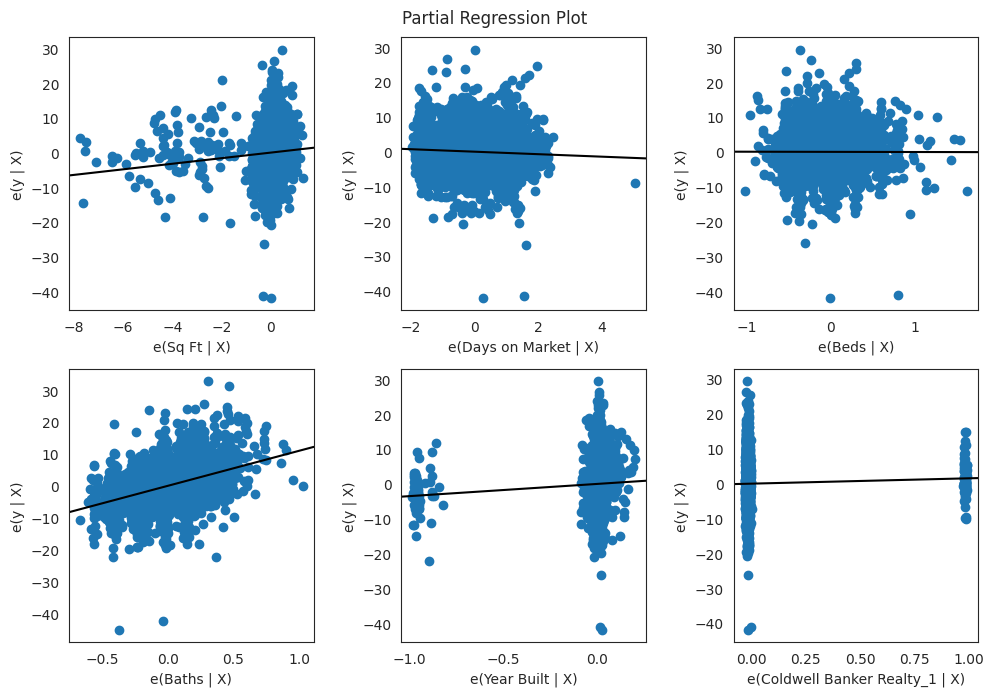

In [23]:
fig = plt.figure(figsize = (10,10))
# Get the exogenous variable names from the model
exog_names = res_transformed.model.exog_names

# Select the desired exogenous variables for the plot
# Assuming you want the first 6 variables after the constant
exog_idx = list(range(1, 7))  # Assuming 'const' is the first variable

# Plot the partial regression grid
sm.graphics.plot_partregress_grid(res_transformed,
                                  exog_idx=exog_idx,  # Use indices instead of column names
                                  grid=(3, 3),
                                  fig=fig)
fig.tight_layout()
plt.show()

Overall, there are some concerns about linearity. On the residual plot, we can see that all residual lines excluding year built are slightly skewed, and the partial regression plot contains not straight lines in almost every variable. Overall, we will continue our assumptions keeping this in mind.

 (I) The residuals are independent (no diagnostic tools - just think about how the data was collected and briefly write your thoughts)

The assumption of independent residuals means that prediction errors for one house price should not be predictable from those of others. However, real estate data often has factors that could introduce dependence. Houses in the same neighborhood might have similar prediction errors due to shared characteristics or market trends as well as if the data might spans a period with changing market conditions, temporal dependence might arise, as houses sold later could have different error patterns. Unobserved factors, like a nearby school's reputation, could further contribute to correlated residuals.

While it's difficult to definitively assess independence without more context about data collection, it's plausible that residuals in this real estate dataset might not be perfectly independent. Keeping this in mind is crucial when interpreting results and making predictions based on the model.

The residuals are normally distributed and centered at zero (use all four diagnostic tools).

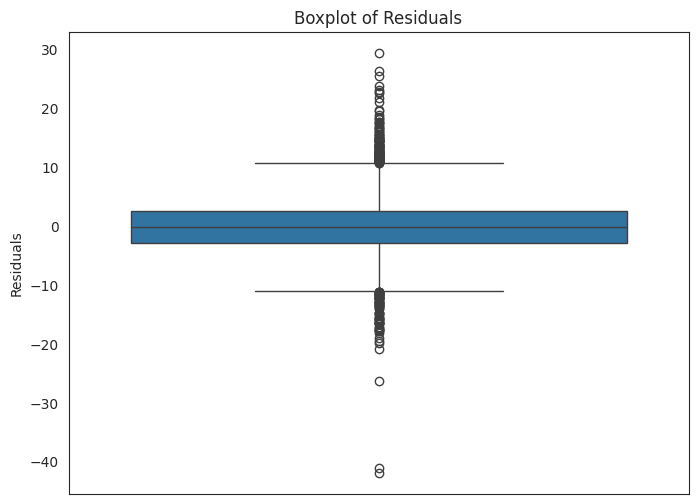

In [24]:
# Create a boxplot of ordered residuals
plt.figure(figsize=(8, 6))
sns.boxplot(y=sampled_df['residuals_transformed'])
plt.ylabel('Residuals')
plt.title('Boxplot of Residuals')
plt.show()


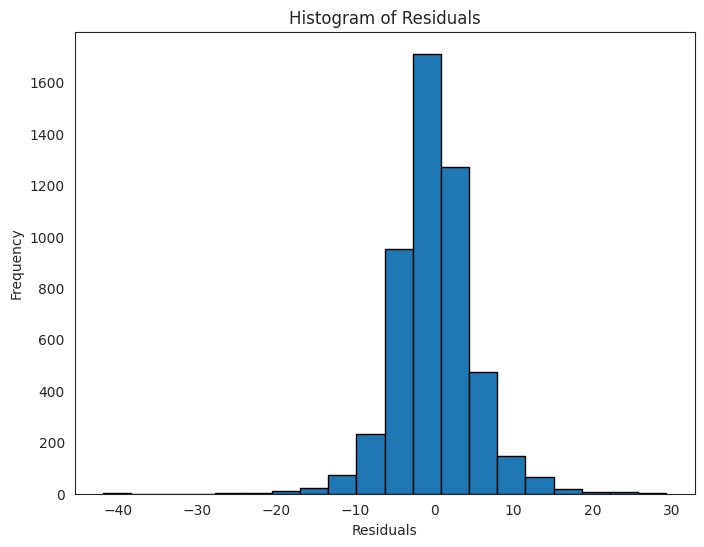

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(sampled_df['residuals_transformed'], bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

<Figure size 800x600 with 0 Axes>

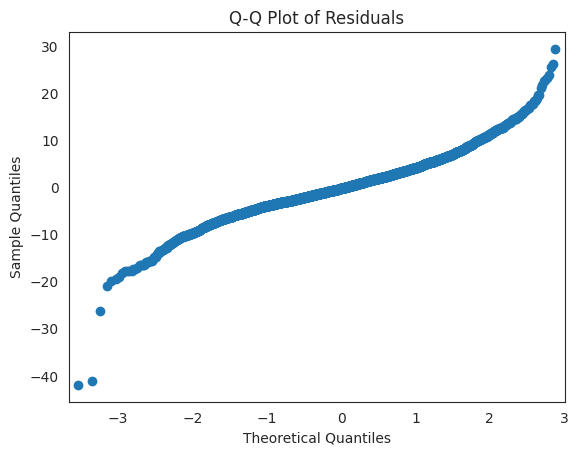

In [26]:
plt.figure(figsize=(8, 6))
sm.qqplot(sampled_df['residuals_transformed'], line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
plt.show()

In [27]:
from scipy.stats import shapiro

statistic, p_value = shapiro(sampled_df['residuals_transformed'])
print(f'Shapiro-Wilk Statistic: {statistic:.3f}')
print(f'P-value: {p_value:.3f}')

Shapiro-Wilk Statistic: nan
P-value: nan


Assessment of Residual Normality and Centering

While the original real estate dataset may not exhibit perfect normality, a key assumption of linear regression is that the residuals are normally distributed and centered at zero. We employed four diagnostic tools to evaluate this assumption: boxplots, histograms, Q-Q plots, and the Shapiro-Wilk test.

Our analysis revealed that the residuals, following data transformations performed during the preparation stage, demonstrate a reasonable degree of normality and centering. While minor deviations from a perfect normal distribution were observed, these are not unexpected given the nature of real estate data (tends to be right skewed due to mansions). Importantly, these minor deviations do not invalidate the model's predictive capabilities, although they should be acknowledged when interpreting statistical inferences.

We believe that the applied data transformations have successfully mitigated potential normality concerns. However, we remain vigilant in monitoring for significant departures from normality and are prepared to make further adjustments if necessary to ensure the reliability of statistical conclusions drawn from the model. Our ongoing assessment of these assumptions will be incorporated into future model refinements and reporting.

(E) The residuals have equal/constant variance across all values of X (only one diagnostic tool).

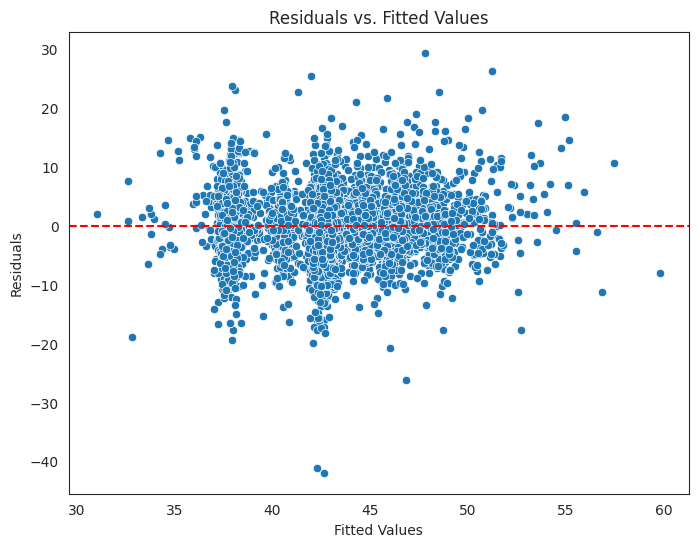

In [28]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=sampled_df['fittedvalues_transformed'], y=sampled_df['residuals_transformed'])
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
plt.show()

Assessment of Homoscedasticity

An essential assumption of linear regression, homoscedasticity, requires that residuals maintain constant variance across all predictor values. We evaluated this using a residual versus fitted values plot, which visually depicts the relationship between predicted values and residuals. Ideally, this plot would show residuals randomly scattered around zero with no discernible pattern of increasing or decreasing spread.

Our analysis of the residual versus fitted values plot indicates a reasonably constant variance across the range of predicted values. While minor fluctuations are observable, they are not substantial enough to raise significant concerns. Therefore, we conclude that the homoscedasticity assumption is adequately met in our model. We will continue to monitor this assumption throughout further model development and validation to ensure its continued validity.

 (A) The model describes all observations (i.e., there are no influential points) (use the DFBETAS and DFFITS).

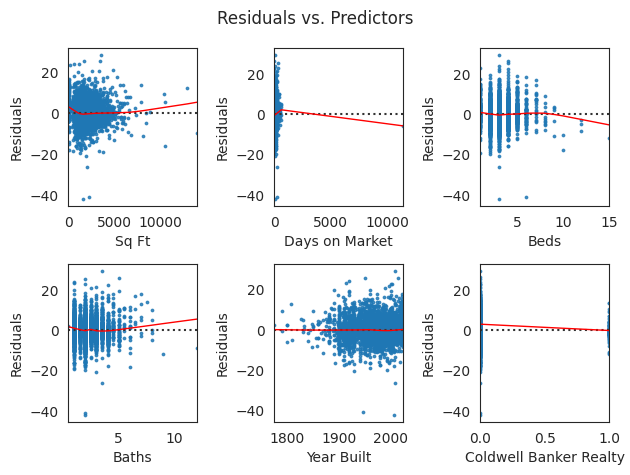

In [29]:
def plot_dfbetas(column, ax, label_level = 2 / np.sqrt(len(sampled_df))):
    idx = sampled_df.columns.get_loc(column)
    sampled_df['dfbetas_' + column] = res_transformed.get_influence().dfbetas[:, idx]

    ax.set_ylabel(column + " DFBETAS (abs)")
    ax.set_xlabel("Observation Number")
    ax.scatter(sampled_df.index, np.abs(sampled_df['dfbetas_' + column]), s = 3)
    ax.axhline(y = label_level, color = 'r', linestyle = 'dashed')

fig, axes = plt.subplots(2, 3)
plt.suptitle("Residuals vs. Predictors")
res_vs_pred("Sq Ft", axes[0, 0])
res_vs_pred("Days on Market", axes[0, 1])
res_vs_pred("Beds", axes[0, 2])
res_vs_pred("Baths", axes[1, 0])
res_vs_pred("Year Built", axes[1, 1])
res_vs_pred("Coldwell Banker Realty", axes[1, 2])
fig.tight_layout()
plt.show()

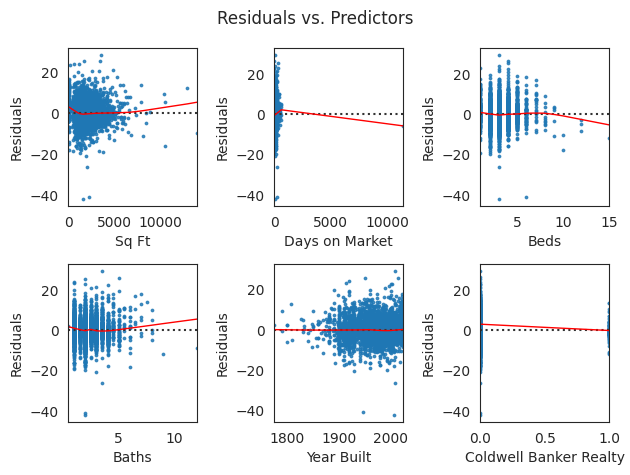

In [30]:
def plot_dffits(ax, label_level=2 / np.sqrt(len(sampled_df))):
    # Calculate DFFITS
    dffits = res_transformed.get_influence().dffits[0]  # Extract the first column if it's 2D

    ax.set_ylabel("DFFITS (abs)")
    ax.set_xlabel("Observation Number")
    ax.scatter(sampled_df.index, np.abs(dffits), s=3)
    ax.axhline(y=label_level, color='r', linestyle='dashed')

fig, axes = plt.subplots(2, 3)
plt.suptitle("Residuals vs. Predictors")
res_vs_pred("Sq Ft", axes[0, 0])
res_vs_pred("Days on Market", axes[0, 1])
res_vs_pred("Beds", axes[0, 2])
res_vs_pred("Baths", axes[1, 0])
res_vs_pred("Year Built", axes[1, 1])
res_vs_pred("Coldwell Banker Realty", axes[1, 2])
fig.tight_layout()
plt.show()

Assessment of Influential Observations

In order to test influential observations, we employed DFBETAS and DFFITS, two diagnostic measures, to detect such influential observations. DFBETAS quantifies the change in regression coefficients, while DFFITS measures the difference in predicted values when an observation is excluded.

Our analysis using DFBETAS and DFFITS revealed numerous observations exceeding established thresholds for undue influence, indicating the model's estimates are potentially sensitive to these outliers. This prevalence of influential data points raises concerns about the model's robustness and overall stability of its findings. We will investigate these influential observations further to determine appropriate mitigation strategies, which may include data transformation, outlier removal, or considering alternative modeling approaches.

. (R) Additional predictor variables are not required (no diagnostic tools - just think about the variables you have and if there are other variables you think would help predict the response).

Our current model incorporates key predictors of real estate prices, including square footage, bedrooms, bathrooms, days on market, year built, and agency representation. These variables reflect important property characteristics and market dynamics commonly associated with price fluctuations, providing a strong foundation for prediction.

While the existing predictors are robust, we acknowledge the potential for enhancing predictive accuracy by incorporating more variables including location-based factors. Variables such as neighborhood demographics, proximity to amenities, school quality, and crime rates could offer valuable insights into price variations. We recommend prioritizing the exploration of these location-related variables in future model iterations to capture a more comprehensive view of market influences. While adding complexity, these variables may significantly improve overall predictive power.

# ***Variable Selection***

In this section, we used backward stepwise selection, sequential replacement, Elastic Band, and LASSO to select variables for our model.

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LinearRegression

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

In [32]:
# Impute missing values with median
sampled_df['Beds'].fillna(sampled_df['Beds'].median(), inplace=True)
sampled_df['Baths'].fillna(sampled_df['Baths'].median(), inplace=True)
sampled_df['Year Built'].fillna(sampled_df['Year Built'].median(), inplace=True)

sampled_df.dropna(subset=['Price'], inplace=True)

# Check again for missing values
X = sampled_df.iloc[:, 1:7]  # Update X as needed based on your columns
y = sampled_df['Price']

print(X.isnull().sum())  # Check for null values in X
print(y.isnull().sum())  # Check for null values in y

Sq Ft                     0
Days on Market            0
Beds                      0
Baths                     0
Year Built                0
Coldwell Banker Realty    0
dtype: int64
0


Backward Stepwise Selection: ('Sq Ft', 'Days on Market', 'Beds', 'Baths', 'Coldwell Banker Realty')


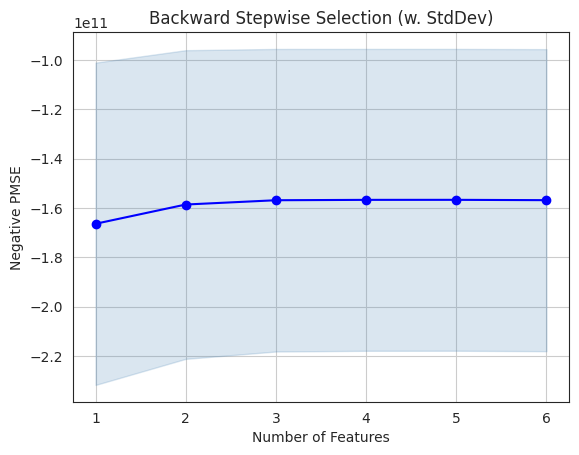

In [33]:
# Backward stepwise selection
backward_selection = SFS(LinearRegression(fit_intercept = True),
                         k_features = (1, len(X.columns)),
                         forward = False,
                         floating = False,
                         scoring = 'neg_mean_squared_error',
                         cv = 5)

backward = backward_selection.fit(X, y)

print('Backward Stepwise Selection:', backward.k_feature_names_)

# Code to plot the (negative) PMSEs
fig1 = plot_sfs(backward.get_metric_dict(), kind = 'std_dev')
plt.title('Backward Stepwise Selection (w. StdDev)')
plt.ylabel("Negative PMSE")
plt.grid()
plt.show()

Using the backward stepwise selection method, the variables Sq Ft, Days on Market, Beds, Baths, and Coldwell Banker Realty are recommended for our model.

Sequential Replacement Stepwise Selection: ('Sq Ft', 'Days on Market', 'Beds', 'Baths', 'Coldwell Banker Realty')


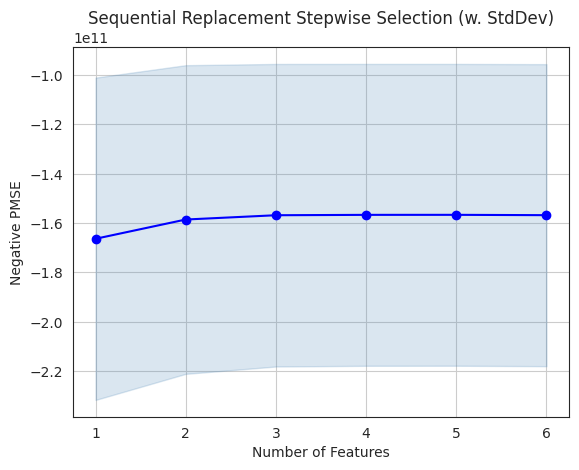

feature_idx                                          cv_scores  \
5     (0, 1, 2, 3, 5)  [-139972168439.9836, -109022126971.37547, -841...   
4        (0, 2, 3, 5)  [-139876175416.42682, -108998202664.72089, -84...   
6  (0, 1, 2, 3, 4, 5)  [-139829550425.09955, -108977715434.83229, -84...   
3           (0, 2, 3)  [-139983107577.7353, -108876363832.87447, -844...   
2              (0, 3)  [-141618733883.37482, -111901922293.8754, -832...   
1                (3,)  [-150336991777.87643, -116306726517.50786, -88...   

             avg_score                                      feature_names  \
5 -156646333297.464935  (Sq Ft, Days on Market, Beds, Baths, Coldwell ...   
4  -156657679339.19696       (Sq Ft, Beds, Baths, Coldwell Banker Realty)   
6 -156781467916.536041  (Sq Ft, Days on Market, Beds, Baths, Year Buil...   
3    -156808479450.487                               (Sq Ft, Beds, Baths)   
2 -158547551124.765686                                     (Sq Ft, Baths)   
1 -166355218201.813446                                           (Baths,)   

             ci_bound             std_dev             std_err  
5  78664215172.165771  61203431909.175903  30601715954.587952  
4  78676412372.279785  61212921745.247192  30606460872.623596  
6  78716583476.401382  61244176229.010124  30622088114.505062  
3  78853943897.093613  61351047302.934311  30675523651.467155  
2  80441868899.819397   62586506902.55661  31293253451.278301  
1  84000317416.716446   65355100741.94799  32677550370.973995

In [34]:
seqrep_selection = SFS(LinearRegression(fit_intercept = True),
                                        k_features = (1, len(X.columns)),
                                        forward = True,
                                        floating = True,
                                        scoring = 'neg_mean_squared_error',
                                        cv = 5)

seqrep = seqrep_selection.fit(X, y)

print('Sequential Replacement Stepwise Selection:', seqrep.k_feature_names_)

# Code to plot the (negative) PMSEs
fig1 = plot_sfs(seqrep.get_metric_dict(), kind = 'std_dev')
plt.title('Sequential Replacement Stepwise Selection (w. StdDev)')
plt.ylabel("Negative PMSE")
plt.grid()
plt.show()

# Code to see the next best models
seqrep_results = pd.DataFrame.from_dict(seqrep.get_metric_dict()).T
seqrep_results_sorted = seqrep_results.sort_values(by = 'avg_score', ascending = False)
seqrep_results_sorted.head(10)

# Code to pull out variable names of 5-variable model
# seqrep_results.sort_index().iloc[3, 2]

Using the sequential replacement method, Sq Ft, Days on Market, Beds, Baths, and Coldwell Banker Realty are recommended for our model.

Minimum alpha: 0.006019481973827274
One SE alpha: 100.0


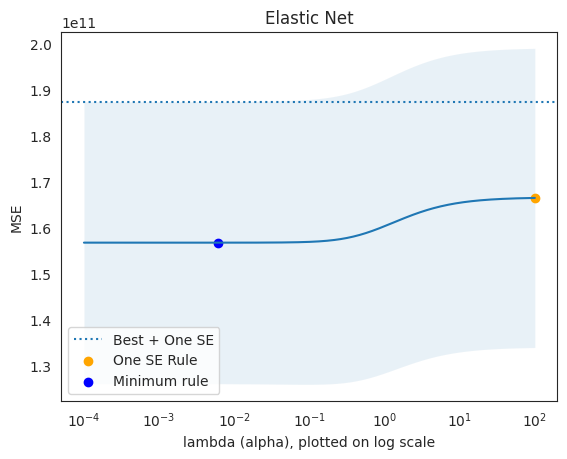

In [35]:
# Elastic Net
# Create a list of possible alphas
potential_alphas = np.logspace(-4, 2, 500)

# run cross-validation to find the best alpha and l1_ratio
ElasticNetCV_model = ElasticNetCV(alphas = potential_alphas,
                                  cv = 5,
                                  random_state = 12345,
                                  max_iter = 10000,
                                  fit_intercept = True)
ElasticNetCV_model.fit(X, y)

# Get the list of alphas and corresponding MSEs
alphas = ElasticNetCV_model.alphas_
pmse_means = np.mean(ElasticNetCV_model.mse_path_, axis = 1)
pmse_std_error = np.std(ElasticNetCV_model.mse_path_,
                        axis = 1,
                        ddof = 1) / np.sqrt(5)  # 5-fold CV

# Find the alpha that minimizes MSE
alpha_index_min = np.argmin(pmse_means)
alpha_min = alphas[alpha_index_min]

# Find the MSE that is one standard error away from the minimum MSE
one_se_above_min = min(pmse_means) + pmse_std_error[alpha_index_min]

# Find the largetst alpha with MSE less than or equal to one_se_above_min
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][0]
alpha_1se = alphas[alpha_index_1se]

print("Minimum alpha:", alpha_min)
print("One SE alpha:", alpha_1se)

# plot
plt.plot(alphas,
         pmse_means)
plt.fill_between(alphas,
                 pmse_means + pmse_std_error,
                 pmse_means - pmse_std_error,
                 alpha = 0.1)
plt.axhline(one_se_above_min,
            linestyle = 'dotted',
            label = 'Best + One SE')
plt.scatter([alpha_1se],
            [pmse_means[alpha_index_1se]],
            marker = 'o',
            color = 'orange',
            label = 'One SE Rule')
plt.scatter([alpha_min],
            [pmse_means[alpha_index_min]],
            marker = 'o',
            color = 'blue',
            label = 'Minimum rule')
plt.legend()
plt.xscale('log')
plt.xlabel('lambda (alpha), plotted on log scale')
plt.ylabel('MSE')
plt.title("Elastic Net")
plt.show()

In [36]:
# Elastic Net results with lambda within one SE of the mean
en_1se = ElasticNet(alpha = alpha_1se,
                     fit_intercept = True)
en_1se.fit(X, y)

# Get coefficients
print(list(zip(en_1se.coef_, X)))

[(219.49904300306767, 'Sq Ft'), (-35.7632115925069, 'Days on Market'), (-213.3182725540224, 'Beds'), (1132.846531496037, 'Baths'), (575.0300038362976, 'Year Built'), (41.953439436137316, 'Coldwell Banker Realty')]


The Elastic Net results indicate that each variable - Sq Ft, Days on Market, Beds, Baths, Year Built, and Coldwell Banker Realty - contributes to the model and should be retained.

In [37]:
# LASSO

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

# Standardize predictors
y = sampled_df['Price'].ravel()
variable_names = X.columns
scaler = StandardScaler().fit(X[variable_names])
X[variable_names] = scaler.transform(X[variable_names])

# Create a list of possible alphas
potential_alphas = np.logspace(-4, 2, 500)
LASSOCV_model = LassoCV(alphas = potential_alphas,
                        cv = 5,
                        random_state = 12345,
                        max_iter = 10000,
                        fit_intercept = True)

# Fit the model
LASSOCV_model.fit(X, y)

# Get the list of alphas and corresponding MSEs
alphas = LASSOCV_model.alphas_
pmse_means = np.mean(LASSOCV_model.mse_path_, axis = 1)
pmse_std_error = np.std(LASSOCV_model.mse_path_,
                        axis = 1,
                        ddof = 1) / np.sqrt(5)  # 5-fold CV

# Find the alpha that minimizes MSE
alpha_index_min = np.argmin(pmse_means)
alpha_min = alphas[alpha_index_min]

# Find the MSE that is one standard error away from the minimum MSE
one_se_above_min = min(pmse_means) + pmse_std_error[alpha_index_min]

# Find the largetst alpha with MSE less than or equal to one_se_above_min
alpha_index_1se = np.where(pmse_means <= one_se_above_min)[0][0]
alpha_1se = alphas[alpha_index_1se]

In [38]:
# LASSO results with lambda within one SE of the mean
LASSO_1se = Lasso(alpha = alpha_1se,
                   fit_intercept = True)
LASSO_1se.fit(X, y)

# Get coefficients
print(list(zip(LASSO_1se.coef_, X)))

[(148287.86065577678, 'Sq Ft'), (-4702.11129576032, 'Days on Market'), (-59761.968885666516, 'Beds'), (158288.64226862128, 'Baths'), (-8212.217800198812, 'Year Built'), (12835.233961755039, 'Coldwell Banker Realty')]


The LASSO results suggest that each variable — Sq Ft, Days on Market, Beds, Baths, Year Built, and Coldwell Banker Realty — adds predictive value and should remain in the model.


**Interpretation/Conclusion**

Using four methods—backward selection, sequential replacement, Elastic Net, and LASSO—we have determined that all variables (Sq Ft, Days on Market, Beds, Baths, Year Built, and Coldwell Banker Realty) should remain in the model. Both backward stepwise selection and sequential replacement indicate that each variable contributes meaningfully, with the exception of Year Built, and both LASSO and Elastic Net assigned non-zero coefficients to all predictors, suggesting they are all relevant.

Based on LASSO and Elastic Net's coefficient sizes, Sq Ft and Baths stand out as the strongest predictors, showing they play a big role in explaining the outcome. Although Year Built was not selected in the backward selection and sequential replacement methods, it was shown to be significant using the shrinkage methods of LASSO and Elastic Net. Since each variable showed potential predictive value across all selection methods, we kept them all in the model.

# ***Model Assessment***

In this section, I backtransformed the variables, residuals, and fitted values and calculated the test statistics R-squared, adjusted R-squared, F-statistic, MAE, MSE, and RMSE for the transformed data. I then calculated the MAE, MSE, and RMSE for the original, backtransformed data.

In [39]:
from scipy.stats import boxcox

# Apply Box-Cox transformation and store the lambda value
price_ex = sampled_df['Price'].values
y_transformed, lambda_value_price = boxcox(price_ex + 1)  # +1 to avoid zeros
y_transformed_ex = pd.Series(y_transformed, index=sampled_df.index)  # Convert to Pandas Series

# Define the inverse Box-Cox transformation
def inverse_boxcox(y_transformed, lam):
    if lam == 0:
        return np.exp(y_transformed) - 1
    else:
        return (y_transformed * lam + 1) ** (1 / lam) - 1


# Back-transform the residuals and fitted values using the lambda
sampled_df['residuals_original'] = inverse_boxcox(res_transformed.resid, lambda_value_price)
sampled_df['fittedvalues_original'] = inverse_boxcox(res_transformed.fittedvalues, lambda_value_price)

# print(sampled_df[['residuals_original', 'fittedvalues_original']].head())

In [40]:
beds_data = sampled_df['Beds'].values

# Box-Cox transformation to Beds and get lambda value
beds_transformed, lambda_beds = boxcox(beds_data + 1)

sampled_df['Beds_transformed'] = beds_transformed

In [41]:
# Back transform variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from scipy.special import inv_boxcox

# Assuming lambda values and scaler objects have been stored as follows:
minmax_scaler = MinMaxScaler()
pt_days_on_market = PowerTransformer(method='yeo-johnson')  # For 'Days on Market' Yeo-Johnson transform

# Inverse transformations functions

# Inverse Box-Cox transformation for Beds
sampled_df['Price_original'] = inv_boxcox(y_transformed, lambda_value_price)

sampled_df['Beds_original'] = inv_boxcox(X_transformed['Beds'], lambda_beds) - 1

# Inverse log transformation for 'Baths' and 'Sq Ft'
sampled_df['Baths_original'] = np.expm1(X_transformed['Baths'])
sampled_df['SqFt_original'] = np.expm1(X_transformed['Sq Ft'])

# print(sampled_df[['Price_original','Beds_original', 'Baths_original', 'SqFt_original', 'Year Built', 'Days on Market']].head())

In [42]:
# Use the back-transformed fitted values and actual price for MAE, MSE, RMSE
mae = np.mean(np.abs(sampled_df['Price'] - sampled_df['fittedvalues_original']))
mse = np.mean((sampled_df['Price'] - sampled_df['fittedvalues_original']) ** 2)
rmse = np.sqrt(mse)

# MAE, MSE, and RMSE for transformed model
transformed_mae = np.sum(np.abs(sampled_df['Price'] - sampled_df['fittedvalues_transformed'])) / (len(sampled_df) - 2)
transformed_mse = np.sum((sampled_df['Price'] - sampled_df['fittedvalues_transformed']) ** 2) / (len(sampled_df) - 2)
transformed_rmse = np.sqrt(transformed_mse)

# Print out the model assessment metrics
print("R-Squared (transformed):", round(res_transformed.rsquared, 4))
print("Adjusted R-Squared (transformed):", round(res_transformed.rsquared_adj, 4))
print("The test statistic for the F-test is ", round(res_transformed.fvalue, 2), " and the corresponding p-value is ", res_transformed.f_pvalue)
print("MAE (original):", mae)
print("MAE (transformed):", transformed_mae)
print("MSE (original):", mse)
print("MSE (transformed):", transformed_mse)
print("RMSE (original):", rmse)
print("RMSE (transformed):", transformed_rmse)


R-Squared (transformed): 0.3182
Adjusted R-Squared (transformed): 0.3174
The test statistic for the F-test is  387.66  and the corresponding p-value is  0.0
MAE (original): 197056.04900577464
MAE (transformed): 466237.85237121914
MSE (original): 169648916325.6755
MSE (transformed): 433803893425.83826
RMSE (original): 411884.59102723846
RMSE (transformed): 658637.9076744963


**Interpretation of results**

The **R-squared value** is 0.3182, or 31.82% when Price is transformed. This indicates that we have a decent model, as 31.82% of the variation in price is explained by the predictors in the model.

The **Adjusted R-squared** value is 0.3174, or 31.74% when Price is transformed. This indicates that the proportion of total variation in price explained by our predictors, adjusted for the number of variables in the model is 31.74%.

The **F-statistic** is 387.66 and the corresponding p-value is 0, which is less than our alpha level of 0.05, which means we have significant evidence to reject the null hypothesis. So, this indicates that al least one of our predictor variables is statistically significant in explaining variation in our transformed Price and that th emodel is statistically valid.

The **Mean Absolute Error (MAE)** for the original, back-transformed data, is 197056.05. This indicates that, on average, the predictions differ from the actual listing prices by about $197056.05.

The **Mean Absolute Error (MAE)** for the transformed data, is 466237.85. This indicates that, on average, the predictions differ from the actual listing prices by about $466237.85.

The **Mean Squared Error (MSE)** for the original, back-transformed data, is 169648916325.68. This statistic estimates the true error variance, and is unfortunately heavily influenced by outliers. However, even though the value is high, this still suggests that our model has some predictive capability. It is important to note that this is not the most reliable model evaluation metric.

The **Mean Squared Error (MSE)** for the transformed data is 433803893425.84. Even though this value is high, it still suggests that our model has some predictive capability. It is important to note that this is not the most reliable model evaluation metric as it is heavily influenced by outliers in the model.

The **Root Mean Square Error (RMSE)** for the original, back-transformed data, is 411884.59. This means that, on average, the predicted values differ from the actual listing prices by about $411884.59.

The **Root Mean Square Error (RMSE)** for the transformed data is 658637.91. So, this means that, on average, the predicted values differ from the actual listing prices by about $658637.91 when price is transformed.

# ***Statistical Inference***

In [43]:
# New model for the back transformed data
X_backtransformed = sampled_df[['SqFt_original', 'Days on Market', 'Beds_original', 'Baths_original', 'Year Built', 'Coldwell Banker Realty']]
X_backtransformed['Year Built'] = X_backtransformed['Year Built'].astype('int64')
y_backtransformed = sampled_df['Price_original']

# Add constant for intercept
X_backtransformed = sm.add_constant(X_backtransformed)

# Fit the model
mod_backtransformed = sm.OLS(y_backtransformed, X_backtransformed)
res_backtransformed = mod_backtransformed.fit()

# Fittedvalues and residuals
sampled_df['fittedvalues_backtransformed'] = res_backtransformed.fittedvalues
sampled_df['residuals_backtransformed'] = res_backtransformed.resid

res_backtransformed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Price_original   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     327.3
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        05:22:43   Log-Likelihood:                -71387.
No. Observations:                4991   AIC:                         1.428e+05
Df Residuals:                    4984   BIC:                         1.428e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.426e+05   3.29e+05      1.346      0.178   -2.02e+05    1.09e+06
SqFt_original            147.8677      8.579     17.236      0.000     131.049     164.687
Days on Market           -27.8006     32.373     -0.859      0.391     -91.266      35.664
Beds_original          -5.583e+04   7067.727     -7.899      0.000   -6.97e+04    -4.2e+04
Baths_original          1.702e+05   9464.380     17.983      0.000    1.52e+05    1.89e+05
Year Built              -236.5147    166.987     -1.416      0.157    -563.882      90.853
Coldwell Banker Realty  9.927e+04    4.3e+04      2.309      0.021     1.5e+04    1.84e+05
==============================================================================
Omnibus:                     6493.302   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2317720.755
Skew:                           6.972   Prob(JB):                         0.00
Kurtosis:                     107.645   Cond. No.                     1.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Hypothesis tests for all slopes on the back transformed data
coefficients_original = res_backtransformed.params
p_values_original = res_backtransformed.pvalues

alpha = 0.05

# Print coefficients and p-values for original data model
for variable, coef, p_val in zip(X_transformed.columns, coefficients_original, p_values_original):
    print(f"Variable: {variable}, Coefficient: {coef}, p-value: {p_val}")

# Check significance on original data
for variable, p_val in zip(X_transformed.columns, p_values_original):
    if p_val < alpha:
        print(f"{variable} is statistically significant on original scale (reject H0).")
    else:
        print(f"{variable} is not statistically significant on original scale (fail to reject H0).")


Variable: const, Coefficient: 442594.4430675928, p-value: 0.17848676093656407
Variable: Sq Ft, Coefficient: 147.86766560935402, p-value: 1.0415107175304628e-64
Variable: Days on Market, Coefficient: -27.800601814692676, p-value: 0.3905118832905894
Variable: Beds, Coefficient: -55828.57643502658, p-value: 3.4311185701941255e-15
Variable: Baths, Coefficient: 170196.69065509064, p-value: 4.1850593136085806e-70
Variable: Year Built, Coefficient: -236.51467688687183, p-value: 0.15673043185481667
Variable: Coldwell Banker Realty_1, Coefficient: 99267.22570576044, p-value: 0.02097401005482078
const is not statistically significant on original scale (fail to reject H0).
Sq Ft is statistically significant on original scale (reject H0).
Days on Market is not statistically significant on original scale (fail to reject H0).
Beds is statistically significant on original scale (reject H0).
Baths is statistically significant on original scale (reject H0).
Year Built is not statistically significant o

***Hypothesis Tests Interpretations***

**Statistically significant:** Sq Ft, Beds, Baths, and Coldwell Banker Realty are all statistically significant as their p-values are less than our alpha level of 0.05. So, we reject the null hypothesis as there is significant evidence that they are useful in predicting Price.


**Not statistically significant:** Days on Market and Year Built are not statistically significant as their p-values are greater than our alpha level of 0.05. So, we fail to reject the null hypothesis for these two variables as there is not significant evidence that they help predict Price.

In [45]:
# Confidence intervals for all slopes
coefficients = res_backtransformed.params
p_values = res_backtransformed.pvalues

# Print coefficients and p-values
for variable, coef, p_val in zip(X_backtransformed.columns, coefficients, p_values):
    print(f"Variable: {variable}, Coefficient: {coef}, p-value: {p_val}")

# 95% Confidence Intervals
alpha = 0.05
conf_int = res_backtransformed.conf_int(alpha)

# Print confidence intervals
print("\n95% Confidence Intervals:")
for variable, ci in zip(X_backtransformed.columns, conf_int.values):
    print(f"{variable}: [{ci[0]:.4f}, {ci[1]:.4f}]")

Variable: const, Coefficient: 442594.4430675928, p-value: 0.17848676093656407
Variable: SqFt_original, Coefficient: 147.86766560935402, p-value: 1.0415107175304628e-64
Variable: Days on Market, Coefficient: -27.800601814692676, p-value: 0.3905118832905894
Variable: Beds_original, Coefficient: -55828.57643502658, p-value: 3.4311185701941255e-15
Variable: Baths_original, Coefficient: 170196.69065509064, p-value: 4.1850593136085806e-70
Variable: Year Built, Coefficient: -236.51467688687183, p-value: 0.15673043185481667
Variable: Coldwell Banker Realty, Coefficient: 99267.22570576044, p-value: 0.02097401005482078

95% Confidence Intervals:
const: [-202224.1434, 1087413.0295]
SqFt_original: [131.0488, 164.6865]
Days on Market: [-91.2655, 35.6643]
Beds_original: [-69684.4326, -41972.7203]
Baths_original: [151642.3410, 188751.0403]
Year Built: [-563.8823, 90.8529]
Coldwell Banker Realty: [14991.8463, 183542.6051]


***Interpretations of 95% Confidence Intervals***


**Sq Ft:** We are 95% confident that the true slope of the relationship between Sq Ft and Price, on the original scale, is between \$131.05 and \$164.69. If the square footage of a property increases by 1 square foot, we expect the price to increase between \$131.05 and \$164.69, on average.

**Days on Market:** We are 95% confident that the true slope of the relationship between Days on Market and Price, on the original scale, is between -\$91.27 and \$35.66. For every additional day that a listing is on the market, we expect the price to change by -\$91.27 and \$35.66, on average. Since zero is contained in this interval, this suggests that this relationship is not statistically significant.

**Beds:** We are 95% confident that the true slope of the relationship between Beds and Price, on the original scale, is between -\$69,684.43 and -\$41,972.72. For every additional bedroom in a listing, we expect the price to decrease between \$69,684.43 and \$41,972.72, on average.

**Baths:** We are 95% confident that the true slope of the relationship between Baths and Price, on the original scale, is between \$151,642.34 and \$188,751.04. For every additional bathroom in a listing, we expect the price to increase between \$151,642.34 and \$188,751.04, on average.

**Year Built:** We are 95% confident that the true slope of the relationship between the year a property was built and Price, on the original scale, is between -\$563.88 and \$90.85. For every additional year since a listing was built, we expect the price to change by between -\$563.88 and \$90.85, on average. Since zero is contained in this interval, this suggests that this relationship is not statistically significant.

**Coldwell Banker Realty:** We are 95% confident that the true slope of the relationship between Coldwell Banker Realty and Price, on the original scale, is between \$14,991.85 and \$183,542.61. So, when a listing is represented by Coldwell Banker Realty, we expect the price to increase by \$14,991.85 and \$183,542, on average.

**Const:** We are 95% confident that the true intercept of the relationship between the predictors and Price, on the original scale, is between -\$202,224.14 and \$1,087,413.03. This value represents the expected price when all of the predictors are zero.

**Confidence Bands**

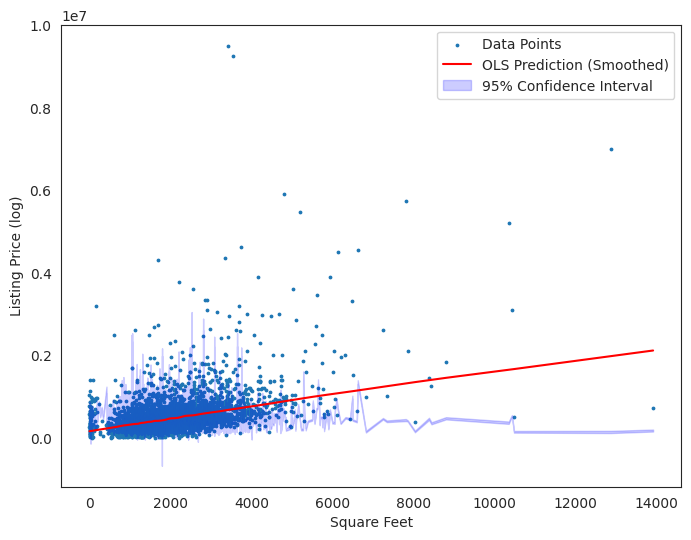

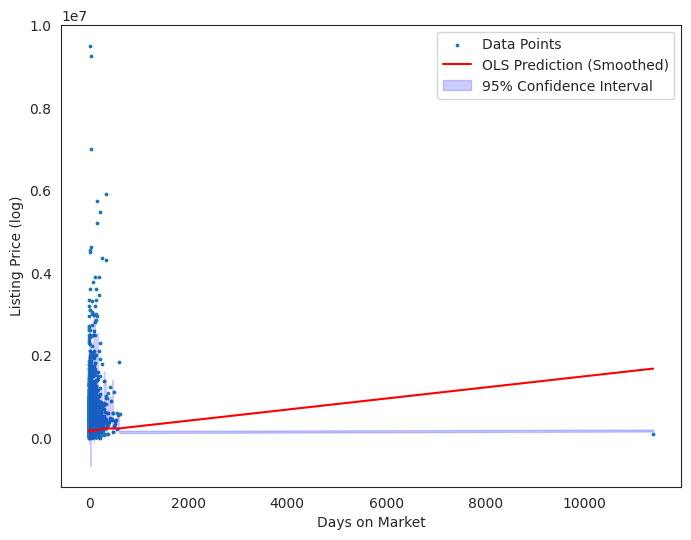

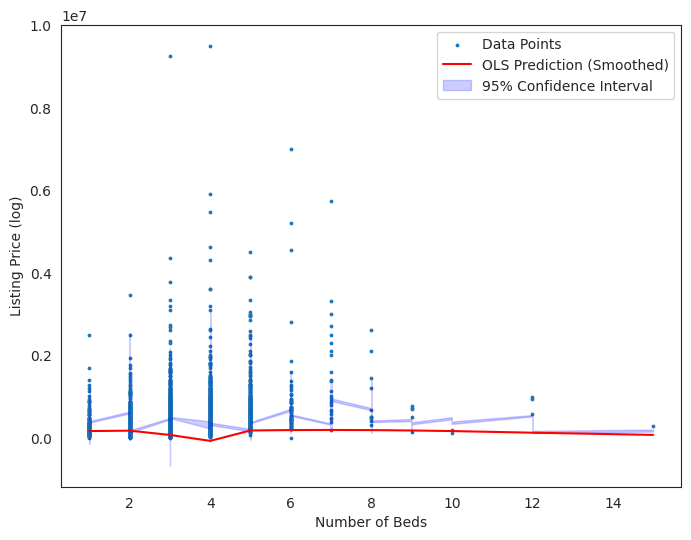

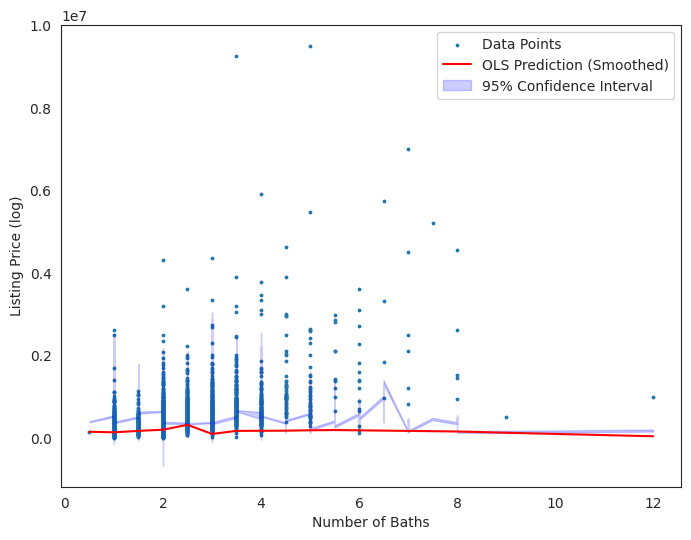

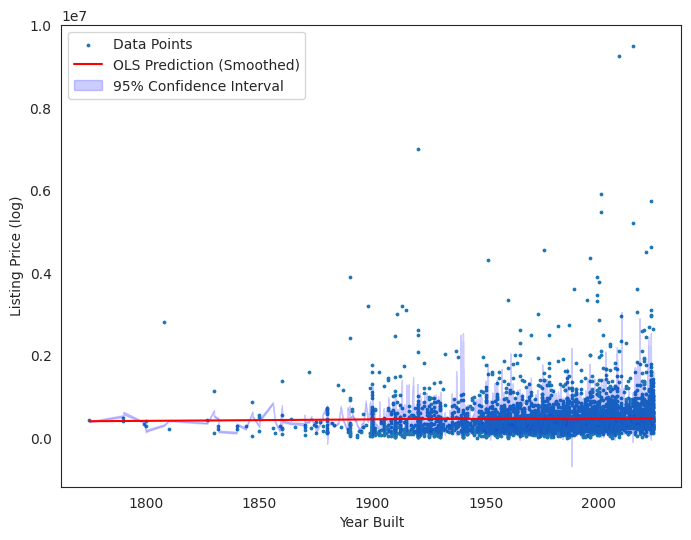

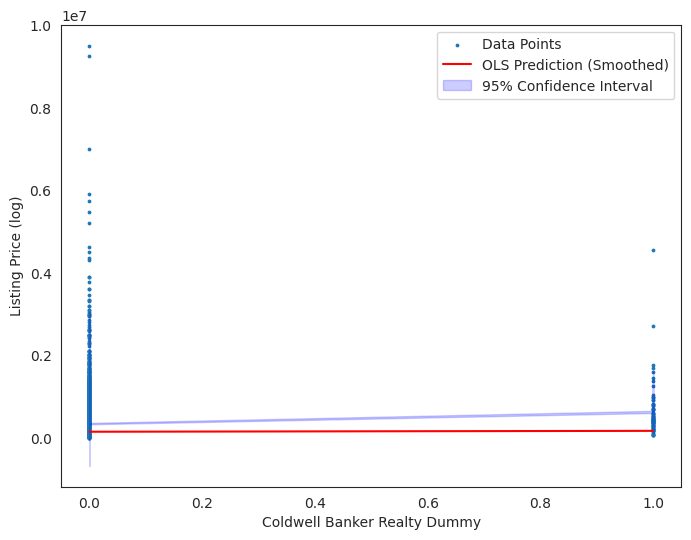

In [46]:
from statsmodels.nonparametric.smoothers_lowess import lowess

mod_backtransformed = sm.OLS(y_backtransformed, X_backtransformed)
res_backtransformed = mod_backtransformed.fit()

# Define the function to plot scatter and regression line with smoothing
def stop_scatter_ols_with_smoothing(x, y, pred_df, x_label):
    # Sort the predictor variable for smoother plotting
    sorted_x = np.sort(x)

    # Get the corresponding predictions for sorted_x
    sorted_X = X_backtransformed.loc[x.index].copy()  # Create a copy of the original X data
    sorted_X['SqFt_original'] = sorted_x  # Replace the column of interest with sorted values
    sorted_pred = res_backtransformed.predict(sorted_X)

    # Apply LOWESS smoothing to the predictions for a smoother curve
    smoothed_preds = lowess(sorted_pred, sorted_x, frac=0.1)  # frac controls the smoothing window size

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=3, label="Data Points")
    plt.plot(smoothed_preds[:, 0], smoothed_preds[:, 1], color="red", label="OLS Prediction (Smoothed)")
    plt.fill_between(sorted_x,
                     pred_df['mean_ci_lower'],
                     pred_df['mean_ci_upper'],
                     color="blue", alpha=0.2, label="95% Confidence Interval")
    plt.xlabel(x_label)
    plt.ylabel("Listing Price (log)")
    plt.legend()
    plt.show()

# Predict and store results with confidence intervals
pred_trans = res_backtransformed.get_prediction(X_backtransformed).summary_frame(alpha=0.05)

# Call the plotting function with data
stop_scatter_ols_with_smoothing(X_backtransformed['SqFt_original'], y_backtransformed, pred_trans, "Square Feet")
stop_scatter_ols_with_smoothing(X_backtransformed['Days on Market'], y_backtransformed, pred_trans, "Days on Market")
stop_scatter_ols_with_smoothing(X_backtransformed['Beds_original'], y_backtransformed, pred_trans, "Number of Beds")
stop_scatter_ols_with_smoothing(X_backtransformed['Baths_original'], y_backtransformed, pred_trans, "Number of Baths")
stop_scatter_ols_with_smoothing(X_backtransformed['Year Built'], y_backtransformed, pred_trans, "Year Built")
stop_scatter_ols_with_smoothing(X_backtransformed['Coldwell Banker Realty'], y_backtransformed, pred_trans, "Coldwell Banker Realty Dummy")


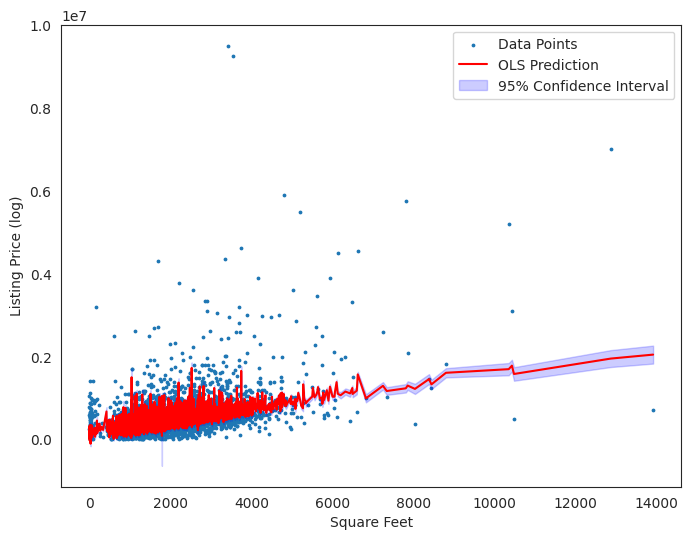

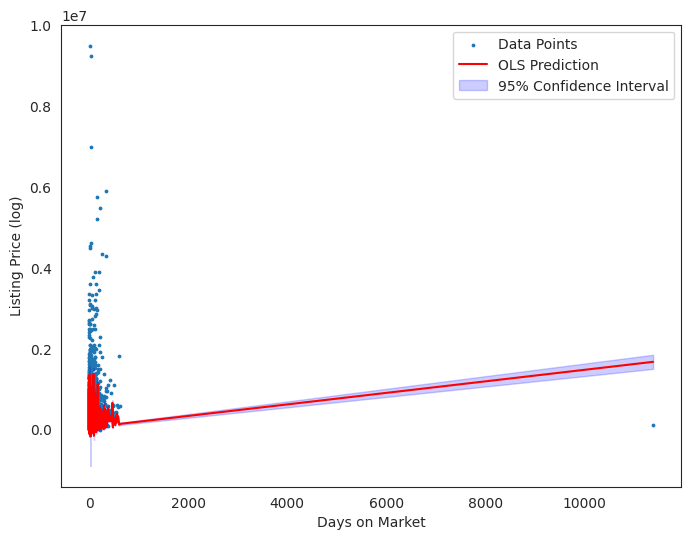

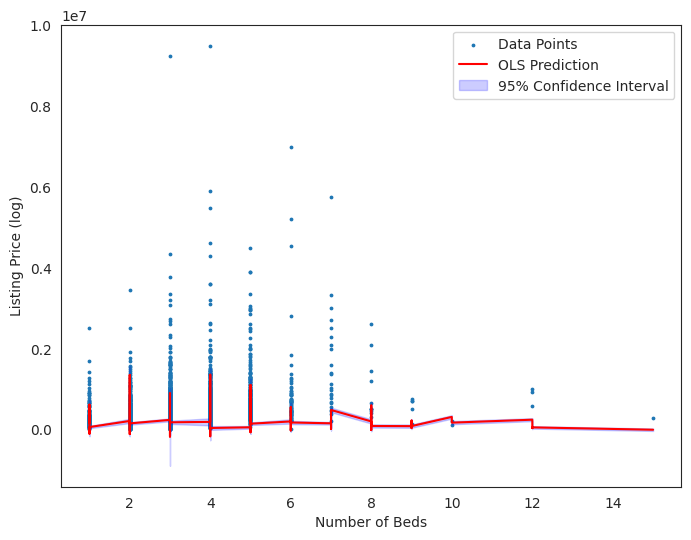

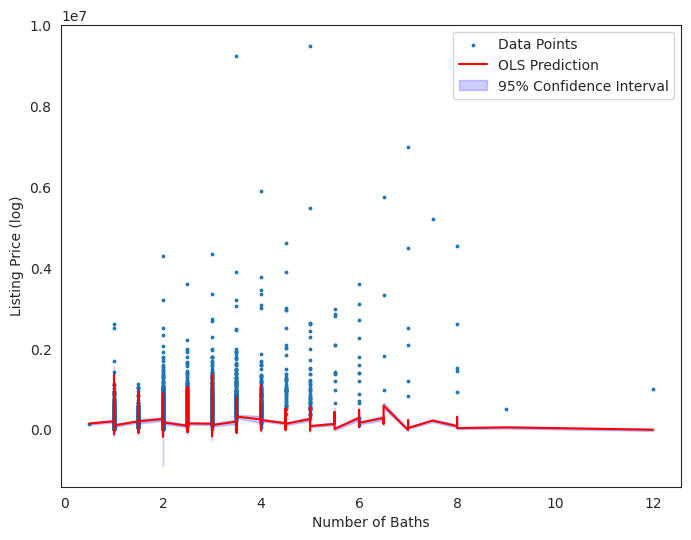

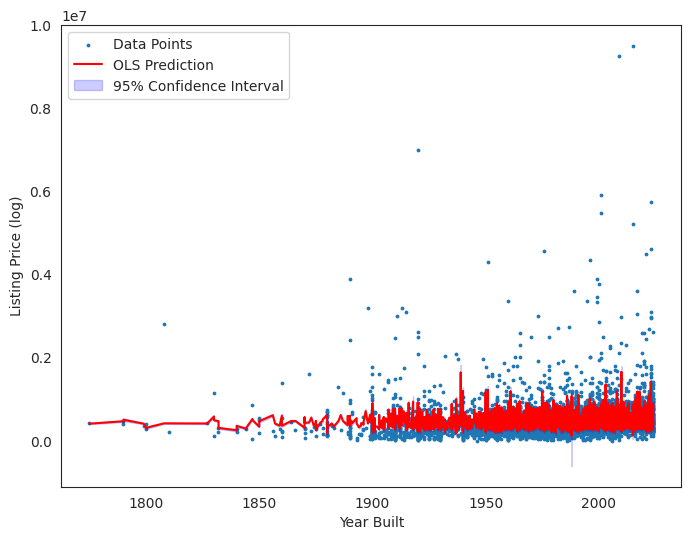

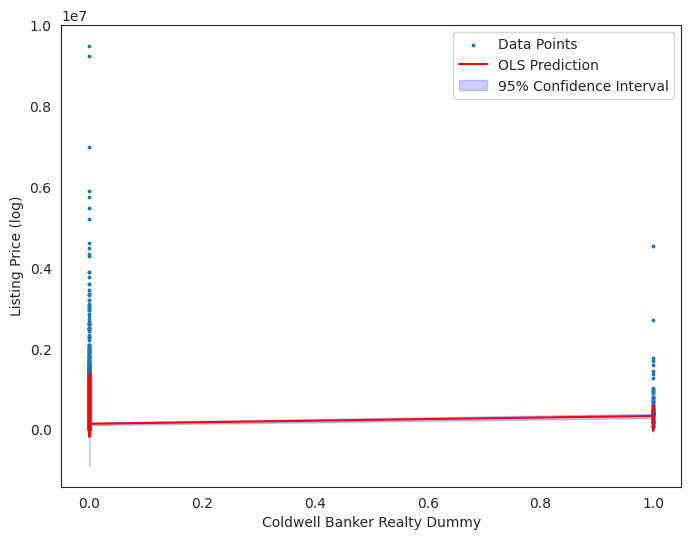

In [47]:
# More descriptive plot
mod_backtransformed = sm.OLS(y_backtransformed, X_backtransformed)
res_backtransformed = mod_backtransformed.fit()

# Define the function to plot scatter and regression line
def stop_scatter_ols(x, y, pred_df, x_label):
    # Sort the predictor variable for smoother plotting
    sorted_x = np.sort(x)

    # Get the corresponding predictions for sorted_x
    sorted_X = X_backtransformed.loc[x.index].copy()  # Create a copy of the original X data
    sorted_X['SqFt_original'] = sorted_x  # Replace the column of interest with sorted values
    sorted_pred = res_backtransformed.predict(sorted_X)

    # Use the sorted predictions to get the fitted curve and confidence intervals
    pred_df_sorted = res_backtransformed.get_prediction(sorted_X).summary_frame(alpha=0.05)

    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, s=3, label="Data Points")
    plt.plot(sorted_x, pred_df_sorted['mean'], color="red", label="OLS Prediction")
    plt.fill_between(sorted_x,
                     pred_df_sorted['mean_ci_lower'],
                     pred_df_sorted['mean_ci_upper'],
                     color="blue", alpha=0.2, label="95% Confidence Interval")
    plt.xlabel(x_label)
    plt.ylabel("Listing Price (log)")
    plt.legend()
    plt.show()

# Predict and store results with confidence intervals
pred_trans = res_backtransformed.get_prediction(X_backtransformed).summary_frame(alpha=0.05)

# Call the plotting function with data
stop_scatter_ols(X_backtransformed['SqFt_original'], y_backtransformed, pred_trans, "Square Feet")
stop_scatter_ols(X_backtransformed['Days on Market'], y_backtransformed, pred_trans, "Days on Market")
stop_scatter_ols(X_backtransformed['Beds_original'], y_backtransformed, pred_trans, "Number of Beds")
stop_scatter_ols(X_backtransformed['Baths_original'], y_backtransformed, pred_trans, "Number of Baths")
stop_scatter_ols(X_backtransformed['Year Built'], y_backtransformed, pred_trans, "Year Built")
stop_scatter_ols(X_backtransformed['Coldwell Banker Realty'], y_backtransformed, pred_trans, "Coldwell Banker Realty Dummy")


**Confidence Interval for the mean of Price (with specific values)**

In [48]:
# Confidence interval for price for a property that is 2000 sq ft, has been on the  market for 45 days, has 3 bedrooms, 2 bathrooms,
# was built in 1995, and is represented by Coldwell Banker Realty
pred = res_backtransformed.get_prediction([1, 2000, 45, 3, 2, 1995, 1])
pred.summary_frame(alpha = 0.05)

mean       mean_se  mean_ci_lower  mean_ci_upper   obs_ci_lower  \
0  537406.844526  43021.704832  453065.370254  621748.318798 -240197.087773   

   obs_ci_upper  
0  1.315011e+06

We are 95% confident that the true mean of Price of a property that is 2000 sq ft, has been on the market for 45 days, has 3 bedrooms, 2 bathrooms, was built in 1995, and is represented by Coldwell Banker Realty is between \$453,065.37 and \$621,748.32, on average.

**Prediction Interval for individual observation**

In [49]:
# Prediction interval for price for a property that is 2000 sq ft, has been on the  market for 45 days, has 3 bedrooms, 2 bathrooms,
# was built in 1995, and is represented by Coldwell Banker Realty

pred = res_backtransformed.get_prediction([1, 2000, 45, 3, 2, 1995, 1])
pred.summary_frame(alpha = 0.05).loc[:, ['obs_ci_lower', 'obs_ci_upper']]

obs_ci_lower  obs_ci_upper
0 -240197.087773  1.315011e+06

We are 95% confident that a property that is 2,000 square feet, has been on the market for 45 days, has 3 bedrooms, 2 bathrooms, was built in 1995, and is represented by Coldwell Banker Realty will have a listing price between -\$240,197.09 and \$1,315,011.00. However, the lower bound is negative, which indicates that we should be cautious when interpreting this prediction interval. The model may produce unrealistic predictions for certain combinations of the predictor values, such as this one. We shouldn't fully trust or rely on these predictions.

The confidence bands are messy and hard to interpret due to the distribution of the data. However, from what we can see, it appears that these plots do somewhat align with the results of the 95% confidence intervals from earlier. However, due to the messiness of the data, it's important that we be extremely cautious when drawing conclusions from these plots.


# Interaction Terms

In this section, interactions in our data are determined and the categorical ones are graphed. Many of the interactions had extremely high VIFs, so they were dropped one by one until the remaining interactions had VIFs less than 5. The remaining interaction was between Coldwell Banker Realty and Days on Market. The interaction model was then compared to the backtransformed model, and it was determined that this interaction did not significantly improve our model, so we decided not to focus on it. We also have several interaction plots, which also did not show significance.

In [50]:
# List of potential significant interactions in our data
X_backtransformed['Beds_Baths'] = X_backtransformed['Beds_original'] * X_backtransformed['Baths_original']
X_backtransformed['SqFt_Baths'] = X_backtransformed['SqFt_original'] * X_backtransformed['Baths_original']
X_backtransformed['SqFt_Beds'] = X_backtransformed['SqFt_original'] * X_backtransformed['Beds_original']
X_backtransformed['SqFt_Days on Market'] = X_backtransformed['SqFt_original'] * X_backtransformed['Days on Market']
X_backtransformed['Beds_Days on Market'] = X_backtransformed['Beds_original'] * X_backtransformed['Days on Market']
X_backtransformed['Baths_Days on Market'] = X_backtransformed['Baths_original'] * X_backtransformed['Days on Market']
X_backtransformed['Year Built_Days on Market'] = X_backtransformed['Year Built'] * X_backtransformed['Days on Market']
X_backtransformed['Year Built_Beds'] = X_backtransformed['Year Built'] * X_backtransformed['Beds_original']
X_backtransformed['Year Built_Baths'] = X_backtransformed['Year Built'] * X_backtransformed['Baths_original']
X_backtransformed['Year Built_SqFt'] = X_backtransformed['Year Built'] * X_backtransformed['SqFt_original']
X_backtransformed['Coldwell_Days on Market'] = X_backtransformed['Coldwell Banker Realty'] * X_backtransformed['Days on Market']
X_backtransformed['Coldwell_Beds'] = X_backtransformed['Coldwell Banker Realty'] * X_backtransformed['Beds_original']
X_backtransformed['Coldwell_Baths'] = X_backtransformed['Coldwell Banker Realty'] * X_backtransformed['Baths_original']
X_backtransformed['Coldwell_SqFt'] = X_backtransformed['Coldwell Banker Realty'] * X_backtransformed['SqFt_original']

# Add a constant for the intercept
X_backtransformed = sm.add_constant(X_backtransformed)

# Fit the updated model
mod_interaction = sm.OLS(y_backtransformed, X_backtransformed)
res_interaction = mod_interaction.fit()

# Get coefficients, p-values, and confidence intervals
coefficients = res_interaction.params
p_values = res_interaction.pvalues
conf_int = res_interaction.conf_int(alpha=0.05)

# Print confidence intervals
print("\n95% Confidence Intervals with interaction:")
for variable, ci in zip(X_backtransformed.columns, conf_int.values):
    print(f"{variable}: [{ci[0]:.4f}, {ci[1]:.4f}]")


95% Confidence Intervals with interaction:
const: [-2180281.3429, 1531766.2091]
SqFt_original: [-2794.9192, -1011.5478]
Days on Market: [-11606.2188, 5153.3647]
Beds_original: [1186854.9131, 2487628.5472]
Baths_original: [-1732871.5101, 122714.8434]
Year Built: [-733.4031, 1156.2697]
Coldwell Banker Realty: [-434500.1593, 78922.4529]
Beds_Baths: [-24181.5106, -6037.3433]
SqFt_Baths: [36.9066, 53.7093]
SqFt_Beds: [-13.9897, 4.7446]
SqFt_Days on Market: [-0.0512, 0.3867]
Beds_Days on Market: [-42.1703, 366.5944]
Baths_Days on Market: [-561.1619, 10.9724]
Year Built_Days on Market: [-2.6718, 5.6628]
Year Built_Beds: [-1259.6376, -600.0525]
Year Built_Baths: [3.8267, 938.7834]
Year Built_SqFt: [0.5158, 1.4102]
Coldwell_Days on Market: [-4507.6588, -51.2451]
Coldwell_Beds: [-96211.0115, 112729.5468]
Coldwell_Baths: [97602.8795, 382435.9875]
Coldwell_SqFt: [-265.1429, 3.4327]


As we can see here, there are a few meaningful interactions. As Beds_Baths, SqFt_Baths, Year Built_Beds, Year Built_Baths, Year Built_SqFt, Coldwell_Days on Market, and Coldwell_Baths all have confidence intervals that do not contain 0, we can assume that these 7 interaction terms are all significant. We can go ahead and drop the remaining interaction terms from our dataframe.

In [51]:
# Dropping the insignificant interactions
X_backtransformed = X_backtransformed.drop(columns=['Coldwell_SqFt', 'Coldwell_Beds', 'SqFt_Beds', 'SqFt_Days on Market', 'Beds_Days on Market', 'Baths_Days on Market', 'Year Built_Days on Market'])
# Drop the rest of the interactions so we can use this model for comparison later
X_backtransformed = X_backtransformed.drop(columns=['Beds_Baths', 'SqFt_Baths', 'Year Built_Beds', 'Year Built_Baths', 'Year Built_SqFt', 'Coldwell_Days on Market', 'Coldwell_Baths'])

In [52]:
# Refit the model so we can use it for comparison later
y_backtransformed = sampled_df['Price_original']  # Make sure 'Price' is defined from your original dataset

# Make sure data types are consistent
X_backtransformed['Year Built'] = X_backtransformed['Year Built'].astype("int64")
X_backtransformed['Coldwell Banker Realty'] = X_backtransformed['Coldwell Banker Realty'].astype("int64")

X_backtransformed = sm.add_constant(X_backtransformed)

mod_backtransformed = sm.OLS(y_backtransformed, X_backtransformed)
res_backtransformed = mod_backtransformed.fit()

# res_backtransformed.summary()

In [53]:
# Fit new model with the interaction terms

y_inter = sampled_df['Price']
X_inter = sampled_df[['SqFt_original', 'Days on Market', 'Beds_original', 'Baths_original', 'Year Built', 'Coldwell Banker Realty']]

# List of potential significant interactions in our data
X_inter['Beds_Baths'] = sampled_df['Beds_original'] * sampled_df['Baths_original']
X_inter['SqFt_Baths'] = sampled_df['SqFt_original'] * sampled_df['Baths_original']
X_inter['Year Built_Beds'] = sampled_df['Year Built'] * sampled_df['Beds_original']
X_inter['Year Built_Baths'] = sampled_df['Year Built'] * sampled_df['Baths_original']
X_inter['Year Built_SqFt'] = sampled_df['Year Built'] * sampled_df['SqFt_original']
X_inter['Coldwell_Days on Market'] = sampled_df['Coldwell Banker Realty'] * sampled_df['Days on Market']
X_inter['Coldwell_Baths'] = sampled_df['Coldwell Banker Realty'] * sampled_df['Baths_original']

# Adjust data types
X_inter['Year Built'] = X_inter['Year Built'].astype("int64")
X_inter['Coldwell Banker Realty'] = X_inter['Coldwell Banker Realty'].astype("int64")
X_inter['Year Built_Days on Market'] = X_inter['Coldwell Banker Realty'].astype("int64")
X_inter['Year Built_Beds'] = X_inter['Year Built_Beds'].astype("float64")
X_inter['Year Built_Baths'] = X_inter['Year Built_Baths'].astype("float64")
X_inter['Year Built_SqFt'] = X_inter['Year Built_SqFt'].astype("float64")

# Add a constant for the intercept
X_inter = sm.add_constant(X_inter)

# Fit the updated model
mod_inter = sm.OLS(y_inter, X_inter)
res_inter = mod_inter.fit()

res_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     171.6
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        05:22:49   Log-Likelihood:                -71292.
No. Observations:                4991   AIC:                         1.426e+05
Df Residuals:                    4977   BIC:                         1.427e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -2.145e+05   9.29e+05     -0.231      0.818   -2.04e+06    1.61e+06
SqFt_original             -2056.2373    442.791     -4.644      0.000   -2924.302   -1188.172
Days on Market              -26.9543     31.798     -0.848      0.397     -89.293      35.384
Beds_original              1.812e+06   3.27e+05      5.549      0.000    1.17e+06    2.45e+06
Baths_original             -7.46e+05   4.69e+05     -1.589      0.112   -1.67e+06    1.74e+05
Year Built                  152.5313    473.092      0.322      0.747    -774.937    1080.000
Coldwell Banker Realty    -6.906e+04   4.72e+04     -1.464      0.143   -1.62e+05    2.34e+04
Beds_Baths                 -1.79e+04   3680.546     -4.864      0.000   -2.51e+04   -1.07e+04
SqFt_Baths                   44.3184      3.902     11.358      0.000      36.669      51.968
Year Built_Beds            -914.6660    165.592     -5.524      0.000   -1239.299    -590.033
Year Built_Baths            443.1484    237.271      1.868      0.062     -22.006     908.303
Year Built_SqFt               1.0349      0.223      4.646      0.000       0.598       1.472
Coldwell_Days on Market   -2370.8623   1127.210     -2.103      0.035   -4580.691    -161.033
Coldwell_Baths             1.264e+05   3.55e+04      3.566      0.000    5.69e+04    1.96e+05
Year Built_Days on Market -6.906e+04   4.72e+04     -1.464      0.143   -1.62e+05    2.34e+04
==============================================================================
Omnibus:                     6376.062   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2397048.609
Skew:                           6.701   Prob(JB):                         0.00
Kurtosis:                     109.522   Cond. No.                     8.33e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.33e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [54]:
# Check VIFs for new model
vif_data = pd.DataFrame()
vif_data["Variable"] = X_inter.columns
vif_data["VIF"] = [variance_inflation_factor(X_inter.values, i) for i in range(X_inter.shape[1])]
print(vif_data)

                     Variable           VIF
0                       const  2.877126e+04
1               SqFt_original  6.583013e+03
2              Days on Market  1.004542e+00
3               Beds_original  4.115364e+03
4              Baths_original  6.367785e+03
5                  Year Built  9.365602e+00
6      Coldwell Banker Realty           inf
7                  Beds_Baths  1.693188e+01
8                  SqFt_Baths  1.504264e+01
9             Year Built_Beds  4.140336e+03
10           Year Built_Baths  6.522796e+03
11            Year Built_SqFt  6.605403e+03
12    Coldwell_Days on Market  1.712589e+00
13             Coldwell_Baths  5.076005e+00
14  Year Built_Days on Market           inf


In [55]:
# Drop columns with high VIFs one at a time to see if it improves the model
X_inter = X_inter.drop(columns=['Year Built_Days on Market'])
X_inter = X_inter.drop(columns=['Year Built_SqFt'])
X_inter = X_inter.drop(columns=['Year Built_Baths'])
X_inter = X_inter.drop(columns=['Year Built_Beds'])
X_inter = X_inter.drop(columns=['SqFt_Baths'])
X_inter = X_inter.drop(columns=['Beds_Baths'])
X_inter = X_inter.drop(columns=['Coldwell_Baths'])

In [56]:
# Updated VIFs after removing variables with high collinearity (VIF > 5)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_inter.columns
vif_data["VIF"] = [variance_inflation_factor(X_inter.values, i) for i in range(X_inter.shape[1])]
print(vif_data)

                  Variable          VIF
0                    const  3481.329257
1            SqFt_original     2.382143
2           Days on Market     1.004433
3            Beds_original     1.859067
4           Baths_original     2.497082
5               Year Built     1.127596
6   Coldwell Banker Realty     1.643373
7  Coldwell_Days on Market     1.648757


In [57]:
# Update model with the remaining interaction term

y_inter = sampled_df['Price']
X_inter = sampled_df[['SqFt_original', 'Days on Market', 'Beds_original', 'Baths_original', 'Year Built', 'Coldwell Banker Realty']]

# Remaining interaction
X_inter['Coldwell_Days on Market'] = sampled_df['Coldwell Banker Realty'] * sampled_df['Days on Market']

# Adjust data types for consistency
X_inter['Year Built'] = X_inter['Year Built'].astype("int64")
X_inter['Coldwell Banker Realty'] = X_inter['Coldwell Banker Realty'].astype("int64")

# Add a constant for the intercept
X_inter = sm.add_constant(X_inter)

# Fit the updated model
mod_inter = sm.OLS(y_inter, X_inter)
res_inter = mod_inter.fit()

res_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     281.1
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        05:22:49   Log-Likelihood:                -71385.
No. Observations:                4991   AIC:                         1.428e+05
Df Residuals:                    4983   BIC:                         1.428e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    4.718e+05   3.29e+05      1.433      0.152   -1.74e+05    1.12e+06
SqFt_original             147.9856      8.577     17.253      0.000     131.170     164.801
Days on Market            -26.1021     32.379     -0.806      0.420     -89.580      37.376
Beds_original           -5.605e+04   7067.207     -7.931      0.000   -6.99e+04   -4.22e+04
Baths_original           1.708e+05   9467.674     18.037      0.000    1.52e+05    1.89e+05
Year Built               -251.7021    167.164     -1.506      0.132    -579.417      76.013
Coldwell Banker Realty   1.608e+05    5.5e+04      2.924      0.003     5.3e+04    2.69e+05
Coldwell_Days on Market -2020.7448   1126.277     -1.794      0.073   -4228.743     187.253
==============================================================================
Omnibus:                     6491.216   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2319904.381
Skew:                           6.967   Prob(JB):                         0.00
Kurtosis:                     107.697   Cond. No.                     1.68e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
from statsmodels.stats.anova import anova_lm

anova_lm(res_backtransformed, res_inter)

df_resid           ssr  df_diff       ss_diff         F    Pr(>F)
0    4984.0  7.749048e+14      0.0           NaN       NaN       NaN
1    4983.0  7.744045e+14      1.0  5.002760e+11  3.219087  0.072845

Including the interaction term Coldwell_Days on Market in our model does not significantly improve our model. We have an F-statistic of 3.22 and a corresponding p-value of 0.07, which indicates that we might want to just focus on our original model.

**Interaction Plots for Categorical Variables**

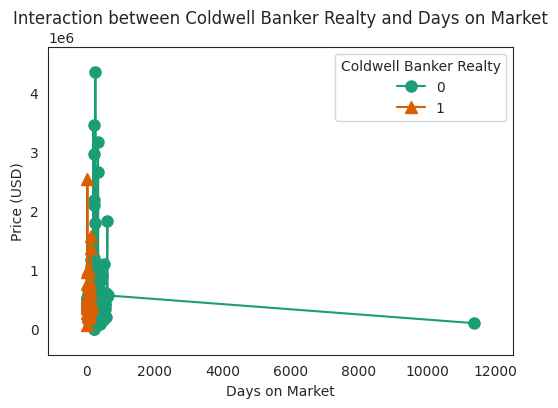

In [59]:
from statsmodels.graphics.factorplots import interaction_plot

# Plot the interaction
fig, ax = plt.subplots(figsize=(6, 4))
fig = interaction_plot(x=sampled_df["Days on Market"],
                       trace=sampled_df["Coldwell Banker Realty"],
                       response=sampled_df["Price_original"],
                       colors=["#1b9e77", "#d95f02"],
                       markers=["o", "^"],
                       ms=8,
                       ax=ax)

ax.set_xlabel('Days on Market')
ax.set_ylabel('Price (USD)')
ax.legend(title='Coldwell Banker Realty', loc='best')
ax.set_title('Interaction between Coldwell Banker Realty and Days on Market')

plt.show()

<Figure size 800x600 with 0 Axes>

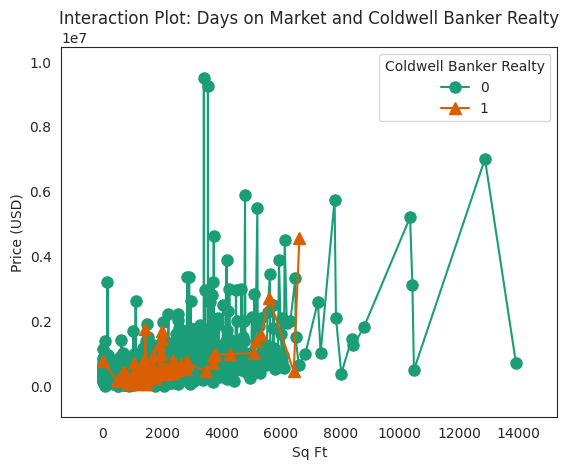

In [60]:
# Interaction plot for Year Built and Coldwell Banker Realty
plt.figure(figsize=(8, 6))
interaction_plot(x=sampled_df['Sq Ft'],
                 trace=sampled_df['Coldwell Banker Realty'],
                 response=sampled_df['Price_original'],
                 colors=['#1b9e77', '#d95f02'],
                 markers=['o', '^'],
                 ms=8)  # marker size
plt.xlabel('Sq Ft')
plt.ylabel('Price (USD)')
plt.title('Interaction Plot: Days on Market and Coldwell Banker Realty')
plt.legend(title='Coldwell Banker Realty')
plt.show()

<Figure size 800x600 with 0 Axes>

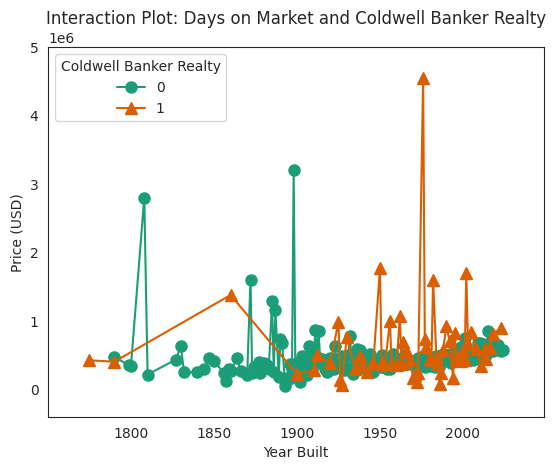

In [61]:
# Interaction plot for Year Built and Coldwell Banker Realty
plt.figure(figsize=(8, 6))
interaction_plot(x=sampled_df['Year Built'],
                 trace=sampled_df['Coldwell Banker Realty'],
                 response=sampled_df['Price_original'],
                 colors=['#1b9e77', '#d95f02'],
                 markers=['o', '^'],
                 ms=8)  # marker size
plt.xlabel('Year Built')
plt.ylabel('Price (USD)')
plt.title('Interaction Plot: Days on Market and Coldwell Banker Realty')
plt.legend(title='Coldwell Banker Realty')
plt.show()

Based on the interaction plots, confidence intervals, and comparison between models (ANOVA test), we can conclude that the interactions are not significantly significant and we will not include them in the model.

Additionally, we do not have every predictor included in our model, so in order to reduce bias, we will not include any interactions in the model.

# **Write-Up**

**Write-up**

Executive Summary

This analysis investigated factors influencing real estate prices using a dataset of property listings. A key finding is that Coldwell Banker Realty exhibits significantly higher average listing prices compared to other agencies in the market. This suggests a potential premium associated with Coldwell Banker's brand or the types of properties they represent.

Furthermore, our analysis identified several key factors that significantly impact real estate prices:

Square Footage: Larger properties command higher prices, indicating a strong positive correlation between size and value.
Number of Bathrooms: Properties with more bathrooms tend to have higher prices, reflecting the added convenience and functionality they offer.
Days on Market: Properties that stay on the market longer tend to have lower sale prices, suggesting that prolonged listing periods may lead to price reductions.
Year Built: Newer properties are generally associated with higher prices, implying that buyers value modern construction and features.
Location-Related Factors: While not explicitly included in the current model, we acknowledge that location plays a significant role in pricing. Factors like neighborhood demographics, school quality, and proximity to amenities are likely to influence property values.
We recommend further investigation of location-based variables to refine the model's predictive accuracy and capture a more comprehensive picture of market dynamics. Overall, this analysis provides valuable insights into the factors driving real estate prices and highlights Coldwell Banker's position in the market. This information can guide strategic decision-making for pricing, marketing, and property acquisition